# Modelos de mezcla {#sec-mixture}

In [2]:
#| code-fold: true

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr

In [3]:
#| code-fold: true

az.style.use('arviz-doc')

El Río de la Plata es el río más ancho de la Tierra y una frontera natural entre Argentina y Uruguay. A finales del siglo XIX, la zona portuaria a lo largo de este río era un lugar donde miembros de pueblos originarios se mezclaban con africanos (la mayoría de ellos esclavos) e inmigrantes europeos. Una consecuencia de este encuentro fue la mezcla de músicas europeas, como el vals y la mazurca, con el candombe africano y la milonga argentina (que, a su vez, es una mezcla de ritmos afroamericanos), dando origen a la danza y la música que conocemos como Tango.

Mezclar elementos previamente existentes es una excelente manera de crear cosas nuevas, no solo en el contexto de la música. En estadística, los modelos mixtos son un enfoque común para la construcción de modelos. Estos modelos se construyen mezclando distribuciones más simples para obtener otras más complejas. Por ejemplo, podemos combinar dos Gaussianas para describir una distribución bimodal o muchas Gaussianas para describir distribuciones arbitrarias. Si bien el uso de Gaussianas es muy común, en principio podemos mezclar cualquier familia de distribuciones que queramos. Los modelos mixtos se utilizan para diferentes propósitos, como modelar directamente subpoblaciones o como un *truco* para lidiar con distribuciones complejas dificiles de describir con las típicas distribuciones de probabilidad.

Los modelos de mezcla surgen naturalmente cuando la población general es una combinación de subpoblaciones distintas. Un ejemplo familiar es la distribución de alturas en una población humana adulta, que puede describirse como una mezcla de subpoblaciones femeninas y masculinas. Otro ejemplo clásico es la agrupación de dígitos escritos a mano. En este caso, es muy razonable esperar 10 subpoblaciones, ¡al menos en un sistema de base 10! 

Si sabemos a qué subpoblación pertenece cada observación, generalmente es una buena idea utilizar esa información para modelar cada subpoblación como un grupo separado. Sin embargo, cuando no tenemos acceso directo a esta información, los modelos de mezcla vienen muy bien.


Al construir un modelo mixto, no es necesario creer que estamos describiendo subpoblaciones reales en los datos. Los modelos mixtos también se pueden utilizar como un truco estadístico para agregar flexibilidad a nuestra caja de herramientas. Tomemos, por ejemplo, la distribución Gaussiana. Podemos usar esta distribución como un aproximación razonable para muchas distribuciones unimodales y aproximadamente simétricas, incluso en algunos casos podemos aproximar datos discretos. Pero ¿qué pasa con las distribuciones multimodales, sesgadas o con colas pesadas? ¿Podemos utilizar distribuciones Gaussianas en estos casos? Si podemos, será cuestión de usar varias distribuciones.

En un modelo de mezcla de Gaussianaa, cada componente será una Gaussiano con una media diferente y potencialmente con una desviación estándar diferente. El número exacto de distribuciones necesarias dependerá de la precisión de la aproximación y de los detalles de los datos. De hecho, hemos estado usando esta estrategia en capítulos anteriores. La técnica de KDE (kernel density estimation) es una implementación no-bayesiana de esta idea. Por ej, cuando llamamos a `az.plot_kde`, la función centra una gaussiana, con una varianza fija, encima de cada dato y luego se combinan todas las Gaussianas individuales. De esta forma logramos aproximar la distribución empírica de los datos a una distribución continua. 

La siguiente figura muestra un ejemplo de cómo podemos combinar 7 Gaussianas para representar una distribución bimodal.

![En azul la densidad no normalizada, resultante de sumar cada Gaussiana (lineas grises puntedas) centrada en una observación (puntos azules)](img/KDE_example.png)

## Modelos de mezclas finitas


Una forma de construir modelos mixtos es considerar una mezcla finita ponderada de dos o más distribuciones. Entonces, la densidad de probabilidad de los datos observados es una suma ponderada de la densidad de probabilidad de $K$ subgrupos:


$$
p(x) = \sum_{i=1}^{K} w_i p(x \mid \theta_i)
$$

Podemos interpretar $w_i$ como la probabilidad del componente $i$, y por lo tanto sus valores están restringidos al intervalo [0, 1] y deben sumar 1. Los componentes $p(x \mid \theta_i) $ suelen ser distribuciones simples, como Gaussiana o Poisson. Si $K$ es finito, tenemos un modelo de mezcla finita, si además $p$ es Gaussiana, tenemos una mezcla Gaussianas. Para resolver dicho modelo, debemos proporcionar un valor de $K$, ya sea porque conocemos el valor correcto de antemano o porque podemos hacer una suposición fundamentada.

Conceptualmente, para resolver un modelo mixto, todo lo que necesitamos hacer es asignar adecuadamente cada punto de datos a uno de los componentes. En un modelo probabilístico, podemos hacer esto introduciendo una variable aleatoria $z$, cuya función es especificar a qué componente se asigna una observación particular. Esta variable generalmente se denomina `variable latente` porque no podemos observarla directamente. Si nuestros componentes son Gaussianos entonces tendremos que:


\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K & \sim N(0, \sigma^2) \\
x & \sim N(\mu_z, \sigma^2)
\end{align*}
\end{split}


Es decir, generamos $K$ Gaussianas y usamos $z$ para indexarlas. $z$ tendrá la misma dimensión que $x$, es decir una variable lantente por observación. $z$ podrá tomar tantos valores como $K$ clases tengamos. Si nuestro modelo es Bayesiano necesitamos completarlo especificando priors, una forma *natural* es establer que $z$ sea una distribución categórica cuyo soporte será 	$\{0, \dots ,K-1\}$ (empezamos en 0 para que luego sea más directa la implementación en Python) y asumimos que el parámetro $p$ de la categórica sigue una distribución de Dirichlet. Para la desviación standard de la gaussiana usamos una media-normal o similar, entonces nos queda:


\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K & \sim N(0, \sigma^2) \\
\sigma & \sim \mathcal{HN}(\dots) \\
\boldsymbol{w} & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
z & \sim \textrm{Cat}(\boldsymbol{w}) \\
y & \sim N(\mu_z, \sigma^2)
\end{align*}
\end{split}

Graficamente tenemos:


<img src="img/mezcla_finita_dag.png" width="400">


El rectángulo de esquinas redondeadas indica que tenemos $K$ componentes y las variables categóricas deciden cuál de ellas usamos para describir un punto de datos determinado. Observe que en este modelo los valores de $\mu$ depende de los diferentes componentes, mientras que el valor de $\sigma$ se comparte para todos ellos. Esto es una decisión de modelado, si fuese necesario podriamos cambiarlo y permitir que se condicionen otros parámetros a cada componente.

## Mezclas químicas

Vamos a utilizar los datos de desplazamientos químicos que ya vimos anteriormente. En la siguiente figura podemos ver un histograma de estos datos.

![Histograma de desplazamientos químicos](img/cs_exp_hist.png)




In [3]:
#| code-fold: true
cs_exp = pd.read_csv("datos/chemical_shifts_theo_exp.csv")["exp"]

Podemos ver que estos datos no se pueden describir adecuadamente usando una sola distribución como una Gaussiana, pero quizá podriamos lograr una mejor descripción si usáramos tres o cuatro. Hay buenas razones teóricas, que ignoraremos y no discutiremos aquí, que indican que estos datos provienen realmente de una mezcla de 40 subpoblaciones. Pero con sólo mirar los datos, parece imposible recuperar los grupos verdaderos ya que hay mucha superposición entre ellos.


En el siguiente bloque de código podemos ver un modelo de mezcla de gaussiana con 2 componentes:

```python
with pm.Model() as modelo_kg:
    w = pm.Dirichlet('w', a=np.ones(2))
    z = pm.Categorical('z', p=w, shape=len(cs_exp))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K)
    σ = pm.HalfNormal('σ', sigma=5)

    x = pm.Normal('x', mu=μ[z], sigma=σ, observed=cs_exp)
    idata_kg = pm.sample()
```

Si ejecutas este código, verás que corre muy lento y si realizas diagnósticos verás que el muestreo tiene muchos problemas ¿Podemos hacer que este modelo funcione más rápido? Sí, veamos cómo.

En el `modelo_kg` hemos incluido explícitamente la variable latente $z$. El muestreo de esta variable discreta generalmente es problemático. Una forma de resolver esto es marginalizando la variable $z$:

\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\sigma & \sim \mathcal{HN}(\dots) \\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
p(x)
    & = \sum_{i = 1}^K w_i\ N(x\ |\ \mu_i, \sigma^2),
\end{align*}
\end{split}

PyMC ofrece una sintáxis más directa para escribir este tipo de modelos, usando la distribución `NormalMixture`:

In [4]:
K = 2
with pm.Model() as modelo_mg:
    w = pm.Dirichlet('w', a=np.ones(K))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K)
    σ = pm.HalfNormal('σ', sigma=5)
    x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


OK, lo primero que notamos es que el modelo corre en un tiempo razonable. Pero tenemos reportes de $\hat R$ altos y ESS bajos! Veamos un foresplot, para lograr entender que está sucediendo

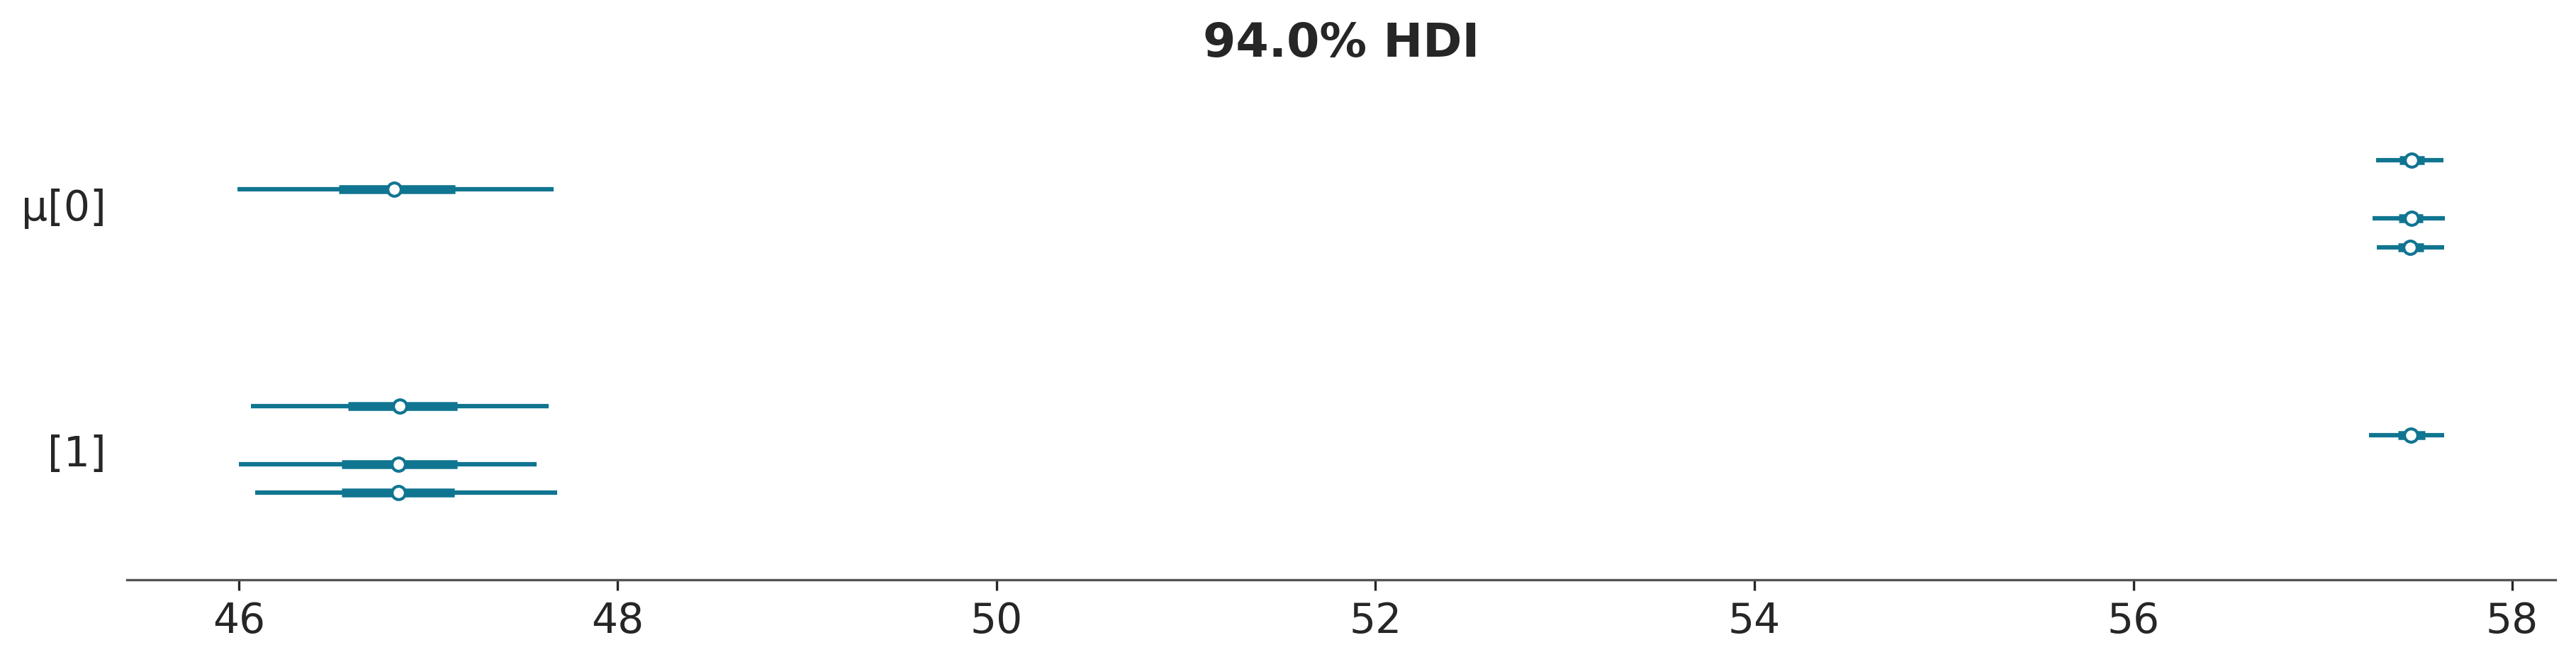

In [5]:
az.plot_forest(idata_mg, var_names="μ", figsize=(12, 3));

Notan algo raro en estos resultados? Tomensé un momento para pensarlo.  

En la figura anterior podemos ver que para `μ[0]` una de las estimaciones está alrededor de 47 y las otras tres alrededor de 57.5. Y lo contrario para `μ[1]`, normalmente esperamos que las distintas cadenas nos den valores cercanos. Cuando los valores son muy diferentes sospechamos que el muestreo ha tenido problemas. Además si calcularamos la media de `μ[0]`, obtendremos un valor cercano a 55 ($57,5 \times 3 + 47 \times 1$), que no es el valor correcto. Lo que estamos viendo es un ejemplo de un fenómeno conocido como **no-identificabilidad** de parámetros. Esto sucede porque, desde la perspectiva del modelo, no hay diferencia si el componente 1 tiene una media de 47 y el componente 2 tiene una media de 57,5 o viceversa; ambos escenarios son equivalentes. En el contexto de los modelos mixtos, esto también se conoce como problema de cambio de etiqueta (label-switching).


## No-identificabilidad

Un modelo estadístico es no-identificable si uno o más de sus parámetros no pueden determinarse de forma única. Los parámetros de un modelo no se identifican si se obtiene la misma función de verosimilitud para más de un conjunto de parámetros. Esto puede suceder por que los datos no contengan suficiente información para estimar los parámetros o por que el modelo es estructuralmente no-identificable, lo que significa que los parámetros no pueden determinarse de manera única incluso si todos los datos necesarios están disponibles.

Con los modelos mixtos, existen al menos dos formas de parametrizar un modelo para eliminar el problema de la no identificabilidad. Podemos forzar un orden arbitrario en los componentes; por ejemplo, establecer que el vector $\mu$ debe ser estrictamente creciente o podemos usar priors informativos. La primer estrategia suele ser más general y simple de implementar y la segunda no garantiza la eliminación de problemas.

Usando PyMC, podemos implementar la primera opción con una transformación:

In [6]:
with pm.Model() as modelo_mgo:
    w = pm.Dirichlet('w', a=np.ones(K))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K,
                 transform=pm.distributions.transforms.ordered,
                 initval=np.array([cs_exp.mean()-1, cs_exp.mean()+1]),
                 )
    σ = pm.HalfNormal('σ', sigma=5)
    x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)    
    
    idata_mgo = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


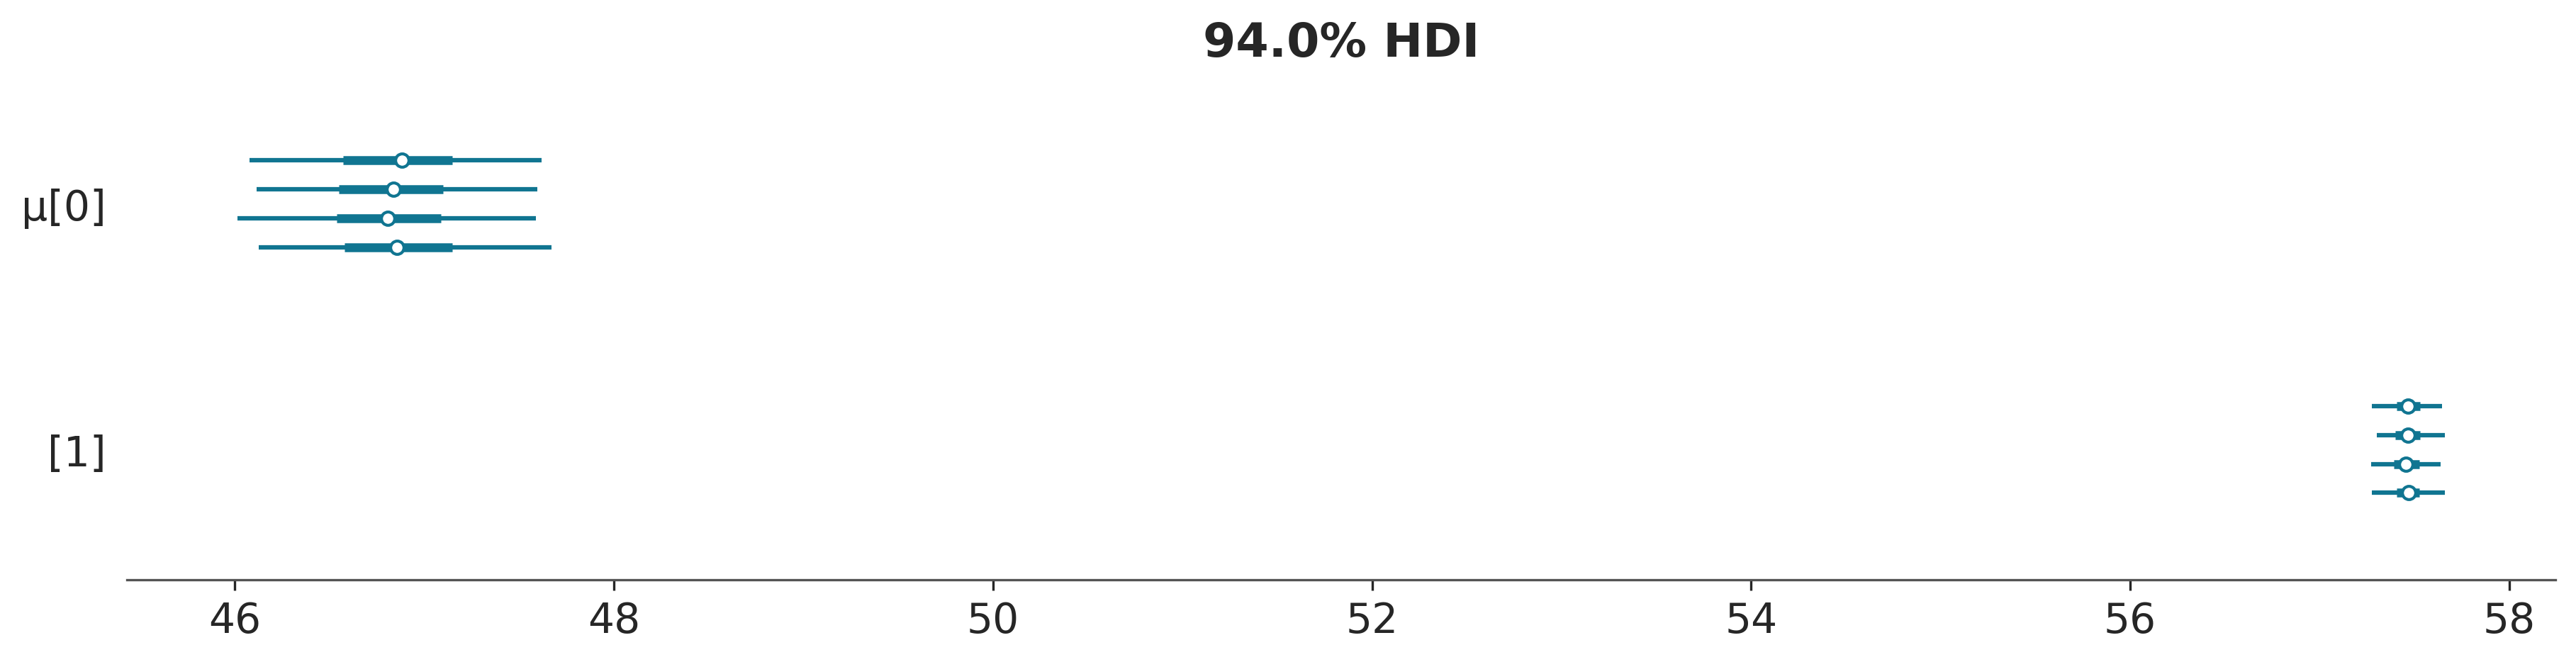

In [7]:
az.plot_forest(idata_mgo, var_names="μ", figsize=(12, 3));

## Como elegir K

Una de las principales preocupaciones con los modelos de mezclas finitas es cómo decidir el número de componentes. Una regla general es comenzar con una cantidad relativamente pequeña de componentes y luego aumentarla para el ajuste del modelo. Como ya vimos anteriormente el ajuste de un modelo se puede evaluar con una combinación de herramientas como las pruebas predictivas a posteriori, el ELPD y la experiencia de los modeladores.

Comparemos el modelo para $K = \{2, 3, 4, 5\}$

In [8]:
np.quantile(cs_exp, np.linspace(0.1, 0.9, 3))

array([51.02, 56.7 , 61.97])

In [9]:
Ks = [2, 3, 4, 5]

models = []
idatas = []
for k in Ks:
    with pm.Model() as model:
        w = pm.Dirichlet('w', a=np.ones(k))
        μ = pm.Normal('μ',
                      mu=np.quantile(cs_exp, np.linspace(0.1, 0.9, k)),
                      sigma=cs_exp.var() / k,
                      shape=k,
                      transform=pm.distributions.transforms.ordered,
                     )
        σ = pm.HalfNormal('σ', sigma=5)
        x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
        idata = pm.sample(random_seed=123,
                          idata_kwargs={"log_likelihood":True}
                         ) 
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


La siguiente figura muestra los modelos de mezcla para $K$ Gaussianas. La linea negra y solida representa la media a posteriori y las lineas turquesa muestras de la distribución a posterori. La distribución media de cada componente está representado usando lineas punteadas

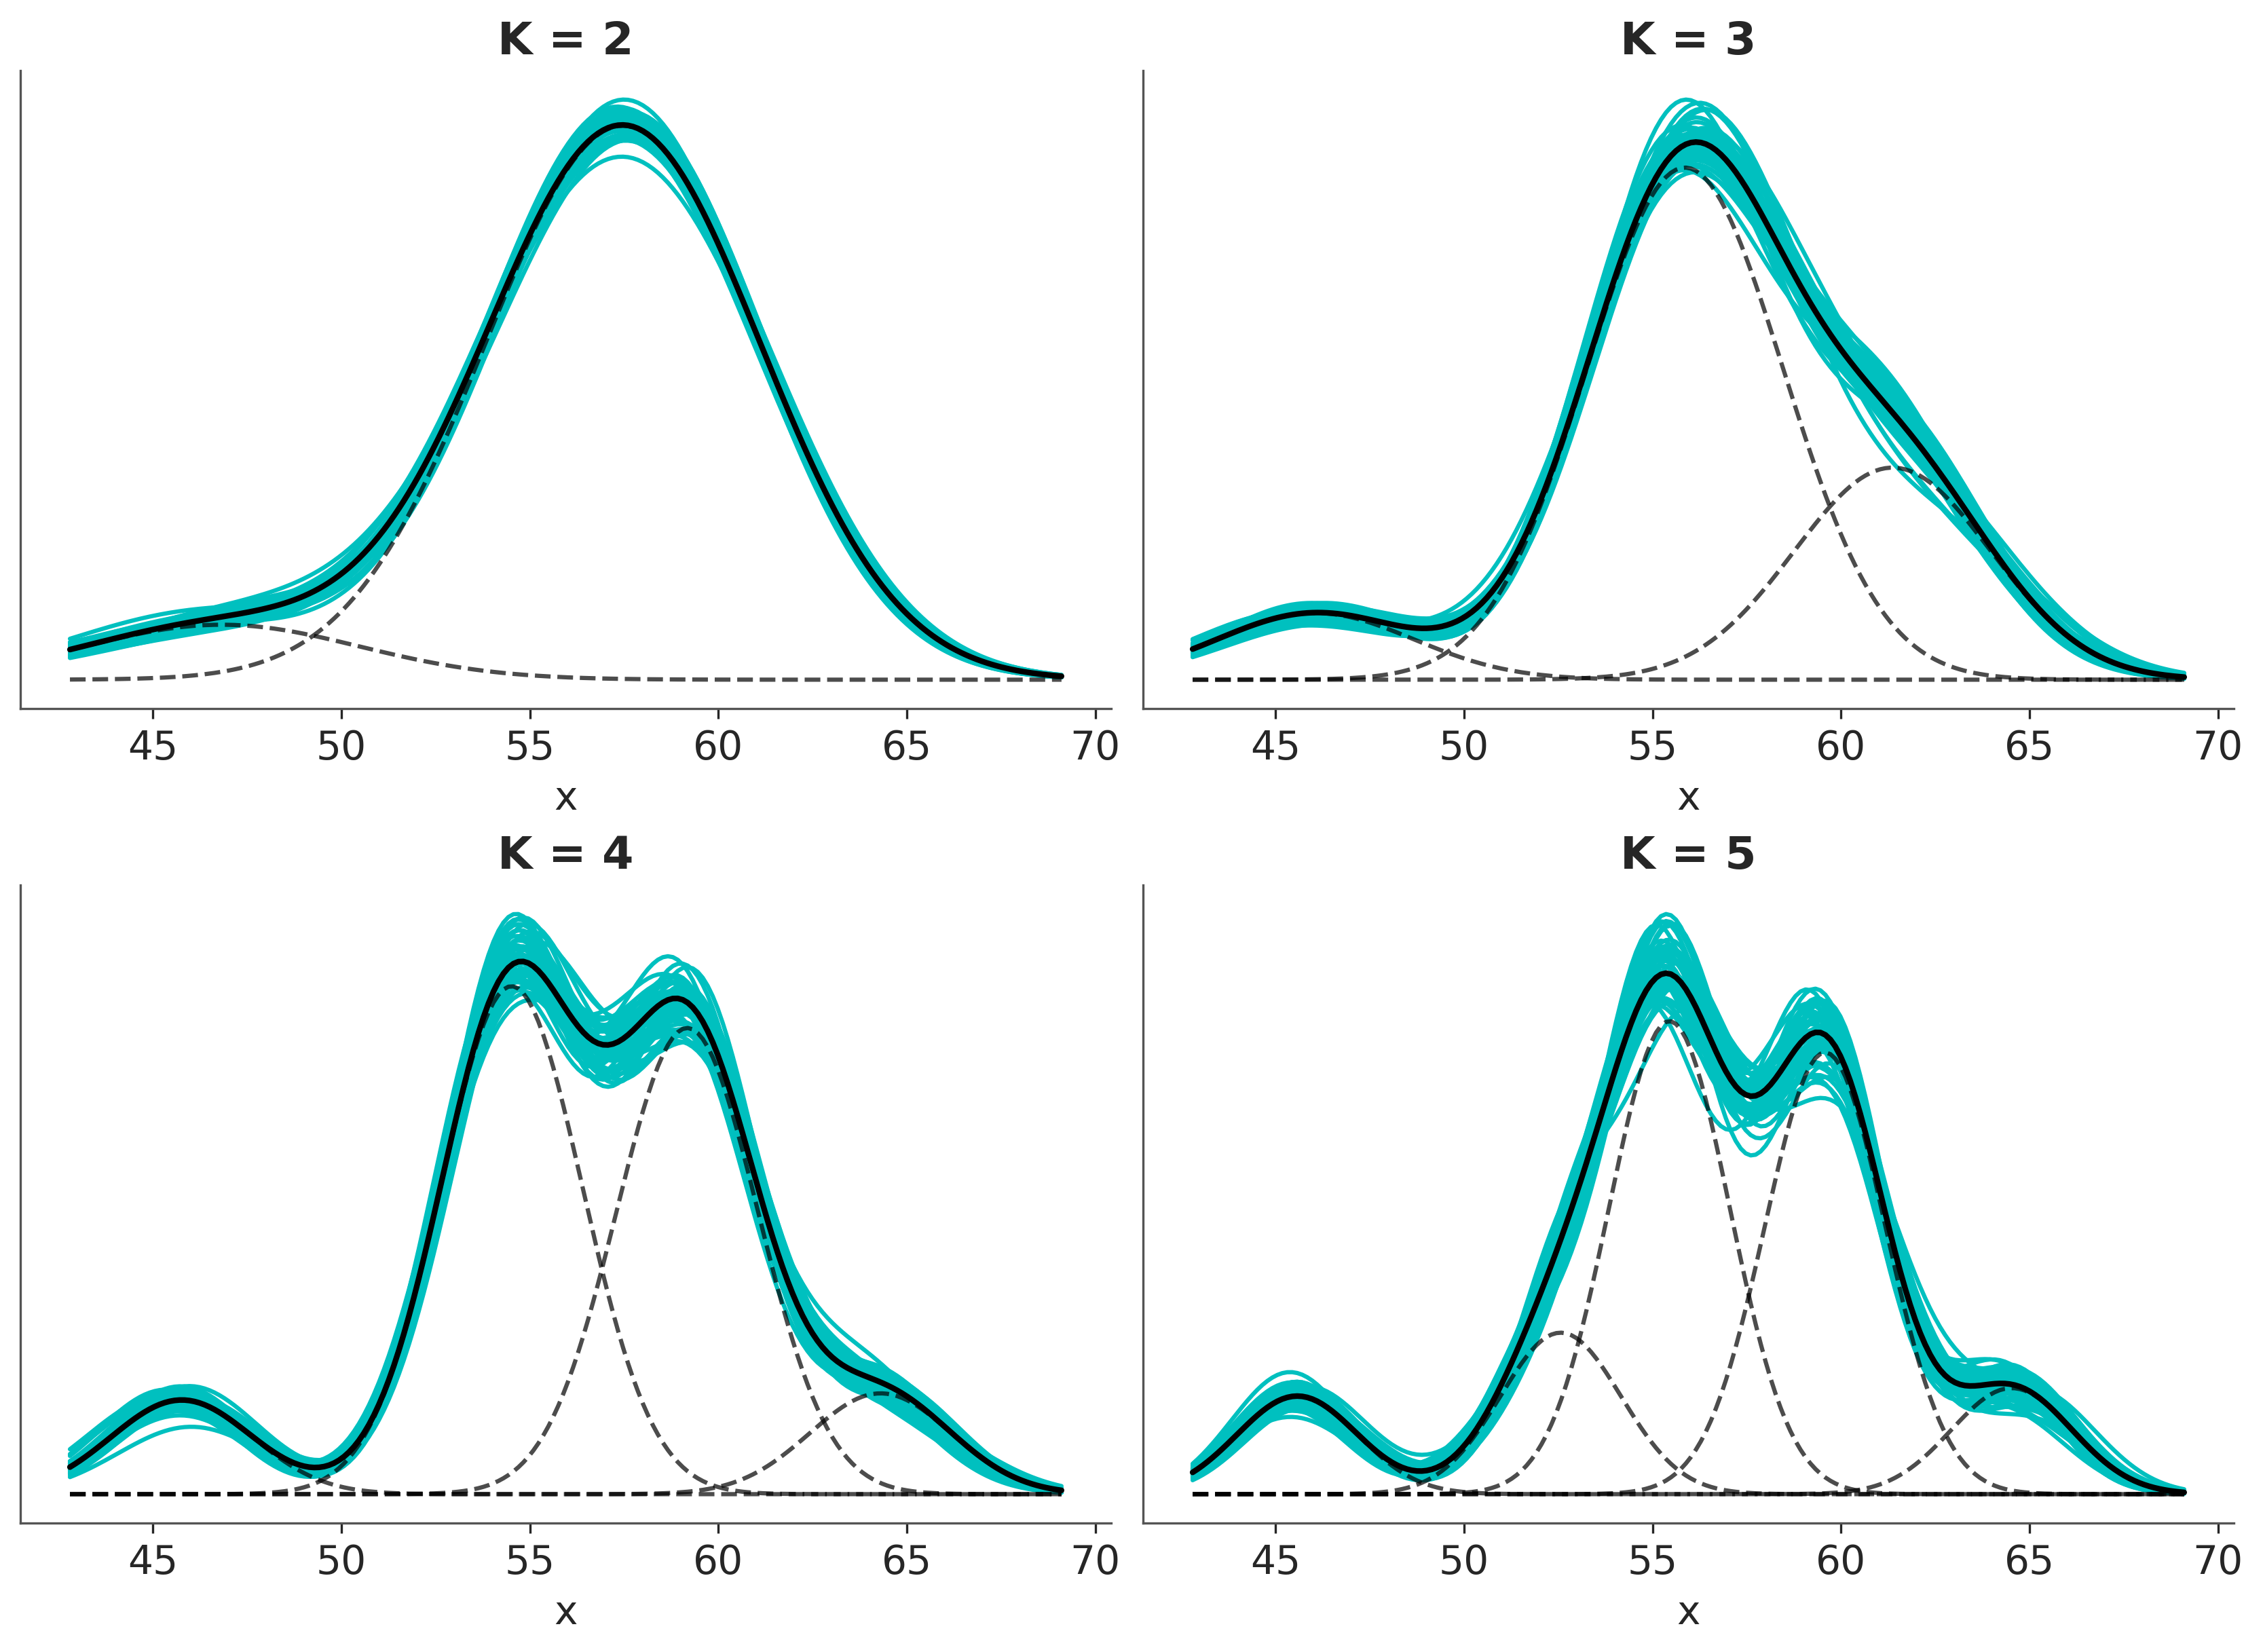

In [10]:
#| code-fold: true
_, ax = plt.subplots(2, 2, figsize=(11, 8))
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * Ks[idx]).T

    for i_ in np.random.randint(0, posterior_x.samples.size, size=50):
        dist = pz.Normal(posterior_x['μ'][:,i_], posterior_x['σ'][i_])
        ax[idx].plot(x, np.sum(dist.pdf(x_) *  posterior_x['w'][:,i_].values, 1), 'C1')
 
    p_y = posterior_x['w'].mean("samples")
    dist = pz.Normal(posterior_x['μ'].mean("samples"), posterior_x['σ'].mean())
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'k', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    ax[idx].set_title('K = {}'.format(Ks[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

Visualmente, parece que $K=2$ es demasiado bajo, pero ¿cómo elegimos un valor mejor? 

Como ya hemos discutido, podemos usar pruebas predictivas a posteriori y calcular valores p bayesianos. La siguiente figura muestra un ejemplo de dicho cálculo y visualización. $K=5$ es la mejor solución y $K=4$ se acerca.

Sampling: [x]
Sampling: [x]
Sampling: [x]
Sampling: [x]


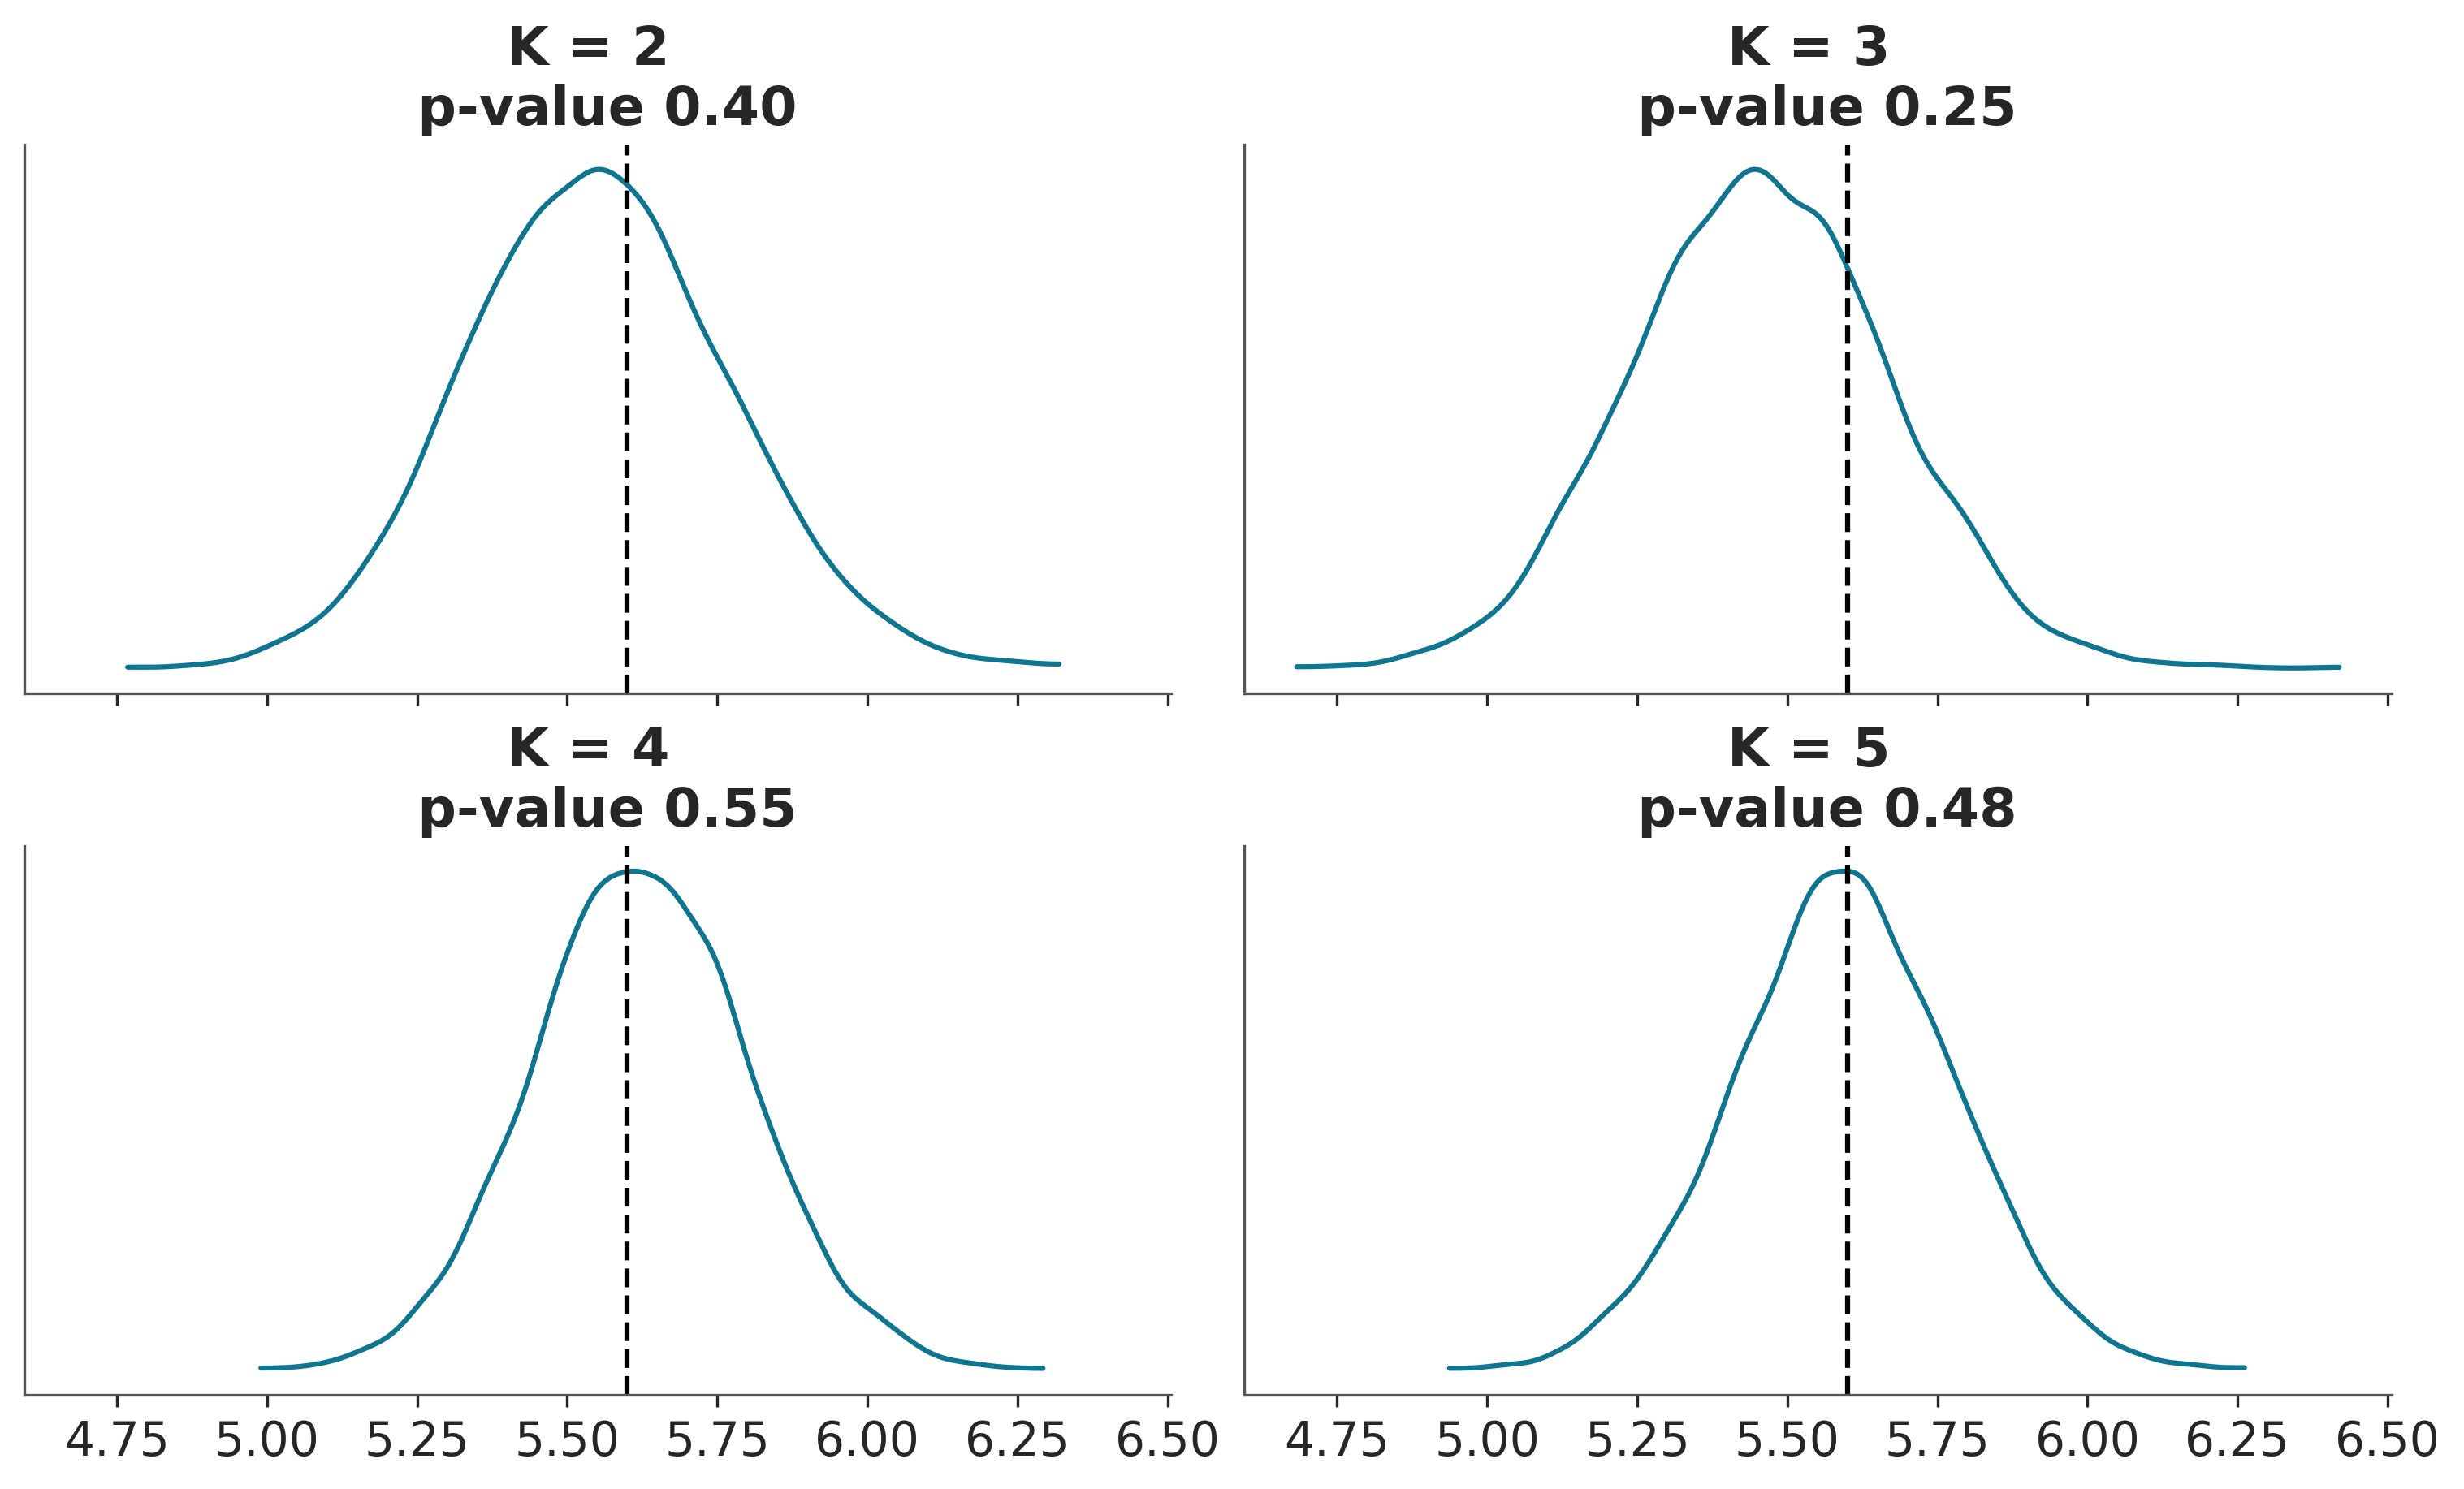

In [11]:
#| code-fold: true
ppc_mm = [pm.sample_posterior_predictive(idatas[i],
                                         models[i],
                                         random_seed=4591,
                                         progressbar=False) for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))
    
T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    d_sim = d_sim.posterior_predictive["x"]
    T_sim = iqr(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {Ks[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

Para complementar estas pruebas, podemos calcular el ELPD usando LOO. Podemos ver que los resultados coinciden con las pruebas predictivas

In [12]:
comp = az.compare(dict(zip([str(K) for K in Ks], idatas)))
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5,0,-5129.384194,9.970668,0.000000,1.000000e+00,30.772529,0.000000,False,log
4,1,-5139.675594,7.686262,10.291400,0.000000e+00,31.282253,3.888748,False,log
3,2,-5178.424336,5.874284,49.040142,0.000000e+00,31.903651,8.746907,False,log
2,3,-5215.947340,3.299947,86.563146,2.437162e-11,33.504264,11.930113,False,log


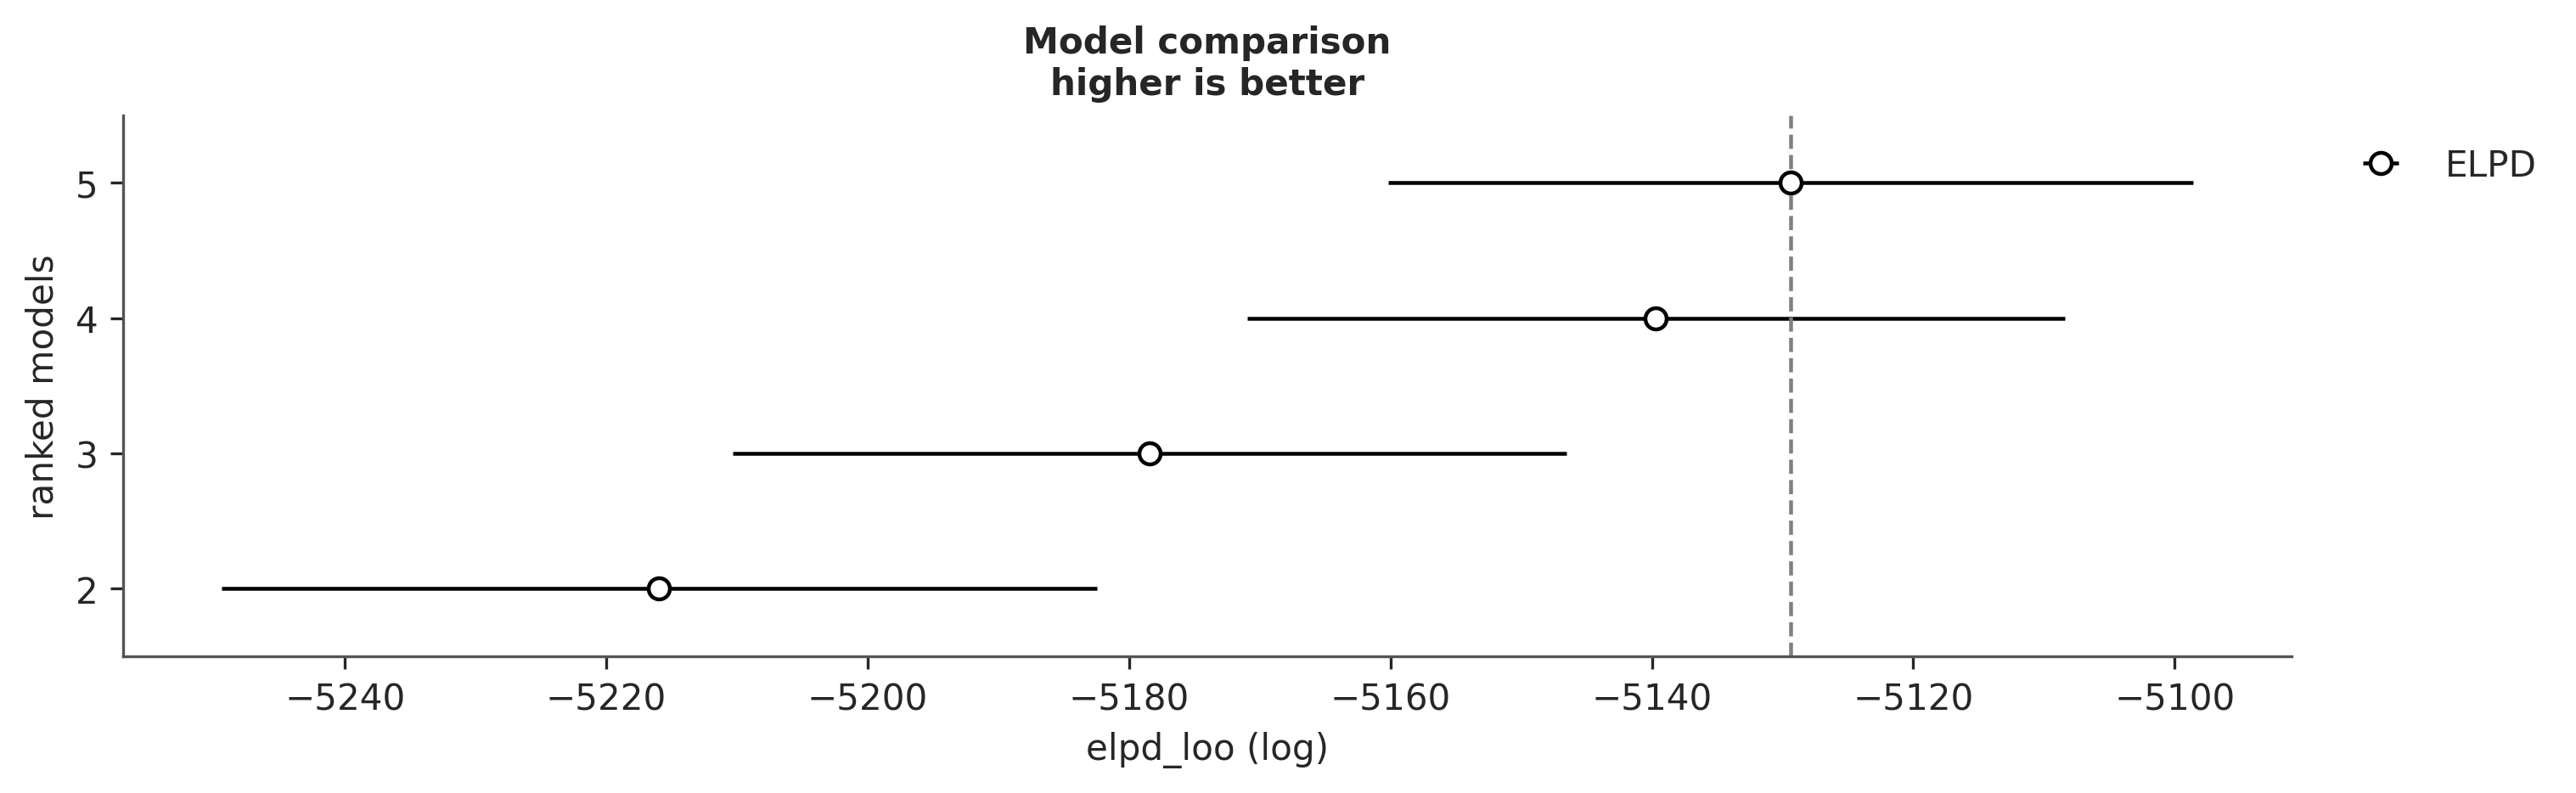

In [13]:
az.plot_compare(comp, figsize=(10, 3), plot_ic_diff=False);

El ejemplo de los desplazamientos químicos, aunque simple, muestra las ideas principales sobre los modelos de mezclas finitas. Para este ejemplo, utilizamos gaussianos porque proporcionan una buena aproximación para modelar los datos. Sin embargo, somos libres de utilizar componentes no gaussianos si es necesario. Por ejemplo, podríamos usar un:


* **Modelo de mezcla de Poisson**: suponga que está monitoreando la cantidad de clientes que ingresan a una tienda cada hora. Un modelo mixto de Poisson puede ayudar a identificar diferentes patrones de tráfico de clientes, como horas o días pico, suponiendo que los datos siguen una combinación de distribuciones de Poisson.
* **Modelo de mezcla exponencial**: Imagina que estás estudiando la vida útil de cierto tipo de bombilla. Un modelo de mezcla exponencial puede ayudar a identificar diferentes grupos de bombillas con diferentes vidas útiles, sugiriendo posibles diferencias en la calidad de fabricación o factores ambientales.


En la siguiente sección, exploraremos dos tipos muy particulares de modelos mixto.

## Modelos zero-inflados y modelos hurdle


Al contar cosas, como autos en una ruta, estrellas en el cielo, lunares en la piel o prácticamente cualquier otra cosa, una posiblidad es no contar nada, es decir, obtener cero. Podemos obtener cero por muchas razones; si estamos en una esquina contando autos rojos por hora podemos contar 0 autos rojos, por que ninguno pasó o por que pasó uno detras de un camión y no lo pudimos ver. Si utilizamos una distribución Poisson o NegativaBinomial para modelar dichos datos, es posible que notemos que el modelo genera menos ceros en comparación con los datos.

¿Cómo arreglamos eso? Una posible solución es suponer que nuestras observaciones siguen un proceso que es en realidad una mezcla de dos procesos:

* Uno modelado por una distribución discreta con probabilidad $\psi$
* Uno dando ceros adicionales con probabilidad $1 - \psi$

Un detalle, simple, pero que nos puede generar sorpresas si no prestamos atención es que en algunos textos (y software) el significado de $\psi$ está invertido, representando la probabilidad de ceros adiciones.

La familia de distribuciones que permiten ceros "adicionales" se conoce como distribución inflada en cero (o cero-inflada). Los miembros más comunes de esa familia son:

* Poisson inflada en cero
* NegativaBinomial inflada en cero
* Binomial inflada en cero


Dada una distribución base con función de masa de probabilidad (PMF). Podemos describir una distribución zero-inflada como:

\begin{split}
f(x \mid \psi, n, p) = \left\{ \begin{array}{l}
    (1-\psi) + \psi \; \text{PMF}(0), \text{si } x = 0 \\
    \psi \; \text{PMF}(x), \text{si } x=1,2,3,\ldots,n
    \end{array} \right.
\end{split}


En la siguiente sección, usaremos Poisson inflado de ceros para resolver un problema de regresión.

## Regresión de Poisson inflada en cero

Para ejemplificar un modelo de regresión de Poisson inflado en cero, vamos a trabajar con un conjunto de datos tomado del [Instituto de Investigación y Educación Digital](http://www.ats.ucla.edu/stat/data). Tenemos 250 grupos de visitantes a un parque, para cada grupo tenemos el registro de la cantidad de peces que capturaron `count`, cuántos niños había en el grupo `child` y si trajeron una casa-rodante/caravana al parque `camper`. Usando estos datos, vamos a construir un modelo de la cantidad de peces capturados en función de las variables de la  cantidd de niños y de la disponibilidad de casa rodante.

In [14]:
pesca = pd.read_csv('datos/pesca.csv')

Usando PyMC podemos escribir un modelo para estos datos como:

In [15]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=2)
    θ = pm.math.exp(α + β[0] * pesca['child'] + β[1] * pesca['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=pesca['count'])
    idata_ZIP_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ψ, α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


`camper` es una variable binaria con 0 si el grupo no entró al parque en casa-rodante y  1 si lo hizo. A una variable que indica la ausencia/presencia de un atributo se le suele llamar variable binaria, dicotómica, "dummy" o variable indicadora. Es importante notar que cuando `camper` toma el valor de 0, el término que involucra a $\beta_1$ también será 0 y el modelo se reduce a una regresión con una sola variable independiente. Ya discutimos esto cuando discutimos el uso de covariables categóricas.


Los resultados se muestran en la siguiente figura. Podemos ver que cuanto mayor es el número de niños, menor es el número de peces capturados. Además, las personas que viajan con una casa-rodante generalmente pescan más. Si revisamos los coeficientes asociados a `child` y `camper`, veremos que podemos decir:

* Por cada niño adicional, el recuento esperado de peces capturados disminuye en $\approx 0,4$
* Acampar con una casa-rodante aumenta la cantidad esperada de peces capturados en $\approx 2$


Los modelos inflados en cero están estrechamente asociados con los modelos hurdle (obstáculos) y puede ser fácil confundirlos. Por lo que es buena idea discutir ambos modelos en simultaneo. 

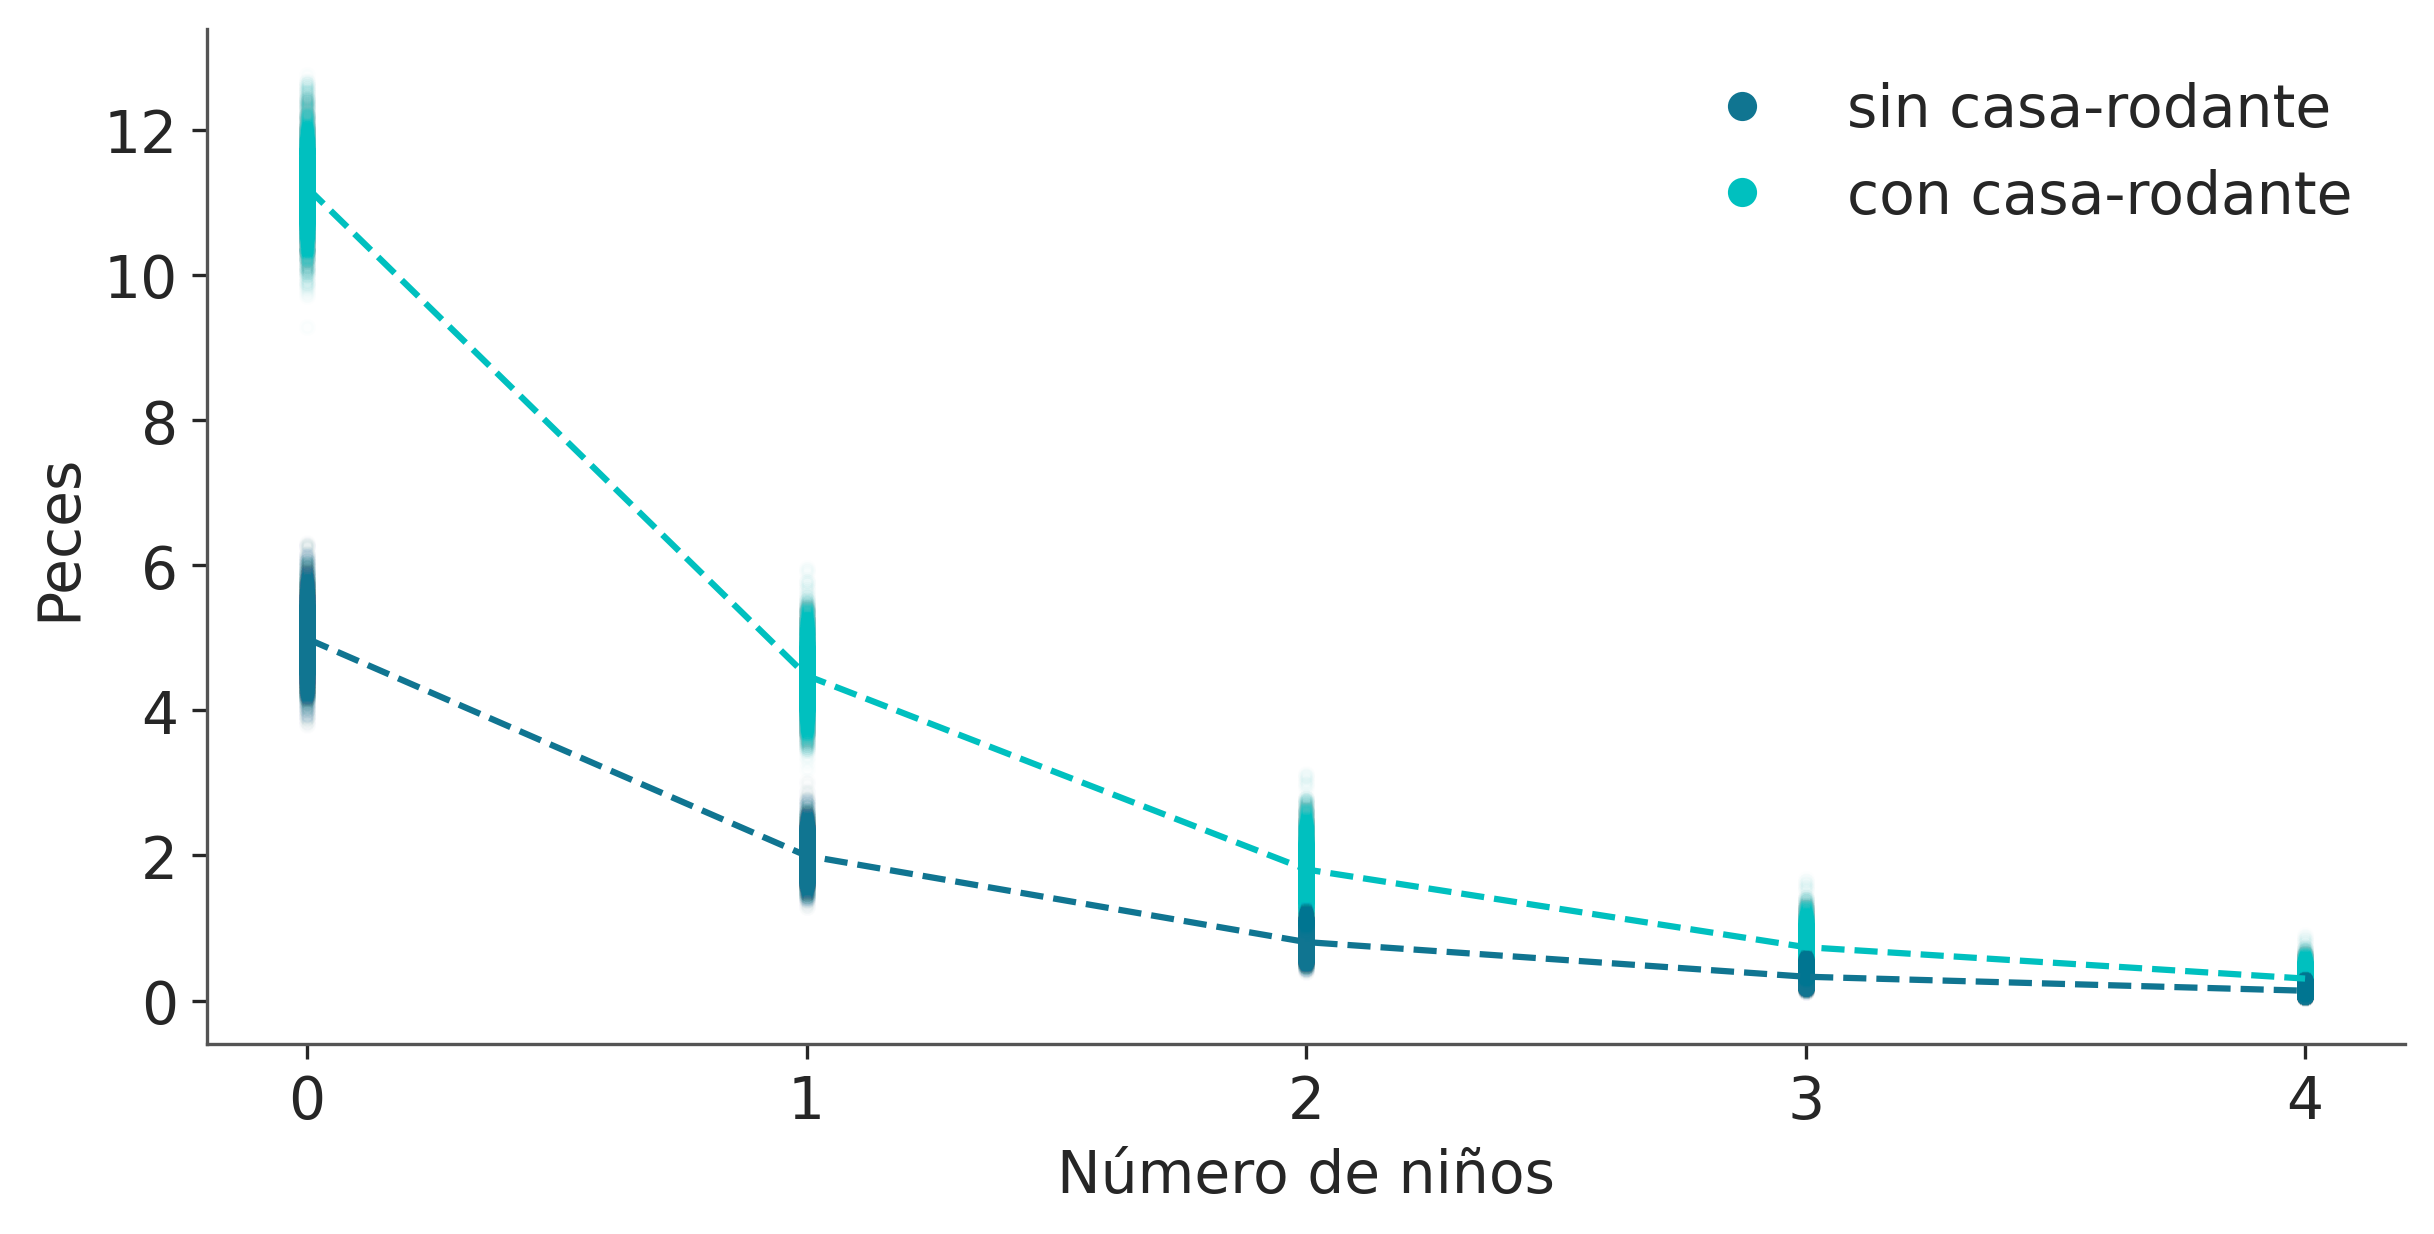

In [16]:
#| code-fold: true
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

posterior = az.extract(idata_ZIP_reg)

without_camper = posterior['α'] + posterior['β'][0] * xr.DataArray(children)
with_camper = without_camper + posterior['β'][1]
fish_count_pred_0 = np.exp(without_camper)
fish_count_pred_1 = np.exp(with_camper)

_, ax = plt.subplots(figsize=(8, 4))
ax.plot(children, fish_count_pred_0.T, 'C0.', alpha=0.01)
ax.plot(children, fish_count_pred_1.T, 'C1.', alpha=0.01)
ax.plot(children, fish_count_pred_0.mean("sample"), 'C0', ls="--")
ax.plot(children, fish_count_pred_1.mean("sample"), 'C1', ls="--")
ax.set_xticks(children)
ax.set_xlabel('Número de niños')
ax.set_ylabel('Peces')
ax.plot([], 'C0o', label='sin casa-rodante')
ax.plot([], 'C1o', label='con casa-rodante')
plt.legend();

### Modelos hurdle

Los modelos de hurdle (obstáculo), también se describien como una mezcla de dos procesos de forma similar a los modelos inflados en cero. La diferencia es que en los modelos hurdles los ceros vienen dados **exclusivamente** con probabilidad $1 - \psi$ y los valores positivos vienen dados por una distribución base truncada en cero. Como consecuencia, un modelo inflado en cero solo puede aumentar la probabilidad de $P(x= 0)$, pero para los modelos hurdle, la probabilidad puede ser mayor o menor que en la distribución base. La razón del nombre hurdle (obstáculo) es que podemos pensar a estas distribuciones como que estamos modelado la presencia de un obstáculo, que hace que nuestra respuesta sea cero, una vez superado el obstáculo la respuesta puede ser distinta de cero.

Algunas "distribuciones hurdle" comunmente usadas son: 

* Poisson Hurdle
* NegativaBinomial Hurdle
* Gamma Hurdle
* Normal Hurdle

Fijensé que contrario a los modelos inflados en cero, cuya distribución base son discretas acá tenemos un par de casos de distribuciones continuas y por lo tanto obtenemos distribuciones que no son continuas ni discretas, si no una mezcla. 

Dada una distribución base con función de distribución acumulada (CDF) y función de masa/densidad de probabilidad (PDF). Podemos describir una distribución Hurdle como:

\begin{split}f(x \mid \psi, \mu) =
    \left\{
        \begin{array}{l}
        (1 - \psi)  \ \text{si } x = 0 \\
        \psi
        \frac{\text{PDF}(x \mid \mu))}
        {1 - \text{CDF}(0 \mid \mu)} \ \text{si } x \not= 0\ldots
        \end{array}
    \right.
\end{split}

Para ilustrar los modelos  hurdle, vamos a utilizar el conjunto de datos del cangrejo herradura [Brockmann_1996](https://onlinelibrary.wiley.com/doi/10.1111/j.1439-0310.1996.tb01099.x). 

Los cangrejos herradura llegan a la playa en parejas para su ritual de desove. Los machos solitarios se agrupan alrededor de las parejas que anidan y compiten por la oportunidad de fertilizar los huevos. Estos individuos, conocidos como machos satélites, a menudo se congregan cerca de ciertas parejas, e ignoran a otras. Queremos modelar el número de `satelites`. Sospechamos que este número está relacionado con las propiedades de las hembras de cangrejo. Como predictores vamos a utilizar propiedades del caparazón `width` y `color`. El color se codifica utilizando los números enteros del 1 al 4, desde tonos más claros a más oscuros.

Usaremos Bambi para escribir y ajustar cuatro modelos. La principal diferencia entre los cuatro modelos es que vamos a utilizar cuatro likelihoods diferentes, a saber, Poisson, Hurdle Poisson, NegativeBinomial y Hurdle NegativeBinomial.

In [17]:
crab = pd.read_csv("datos/horseshoe_crab.csv")

In [18]:
familias = ["poisson", "hurdle_poisson", "negativebinomial", "hurdle_negativebinomial"]

modelos = []
idatas = []

for familia in familias:
    modelo = bmb.Model("satellite ~ width + C(color)", family=familia, data=crab)
    idata = modelo.fit(idata_kwargs={"log_likelihood":True}, random_seed=123)
    modelo.predict(idata, kind="pps")
    idatas.append(idata)
    modelos.append(modelo)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_psi, Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_alpha, Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_psi, satellite_alpha, Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Primero hagamos una comparación en términos del ELPD 

In [19]:
cmp = az.compare(dict(zip(familias, idatas)))
cmp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hurdle_negativebinomial,0,-372.673065,6.165628,0.000000,3.249791e-14,13.672084,0.000000,False,log
negativebinomial,1,-380.355948,5.654806,7.682883,4.159461e-01,14.122017,5.692175,False,log
hurdle_poisson,2,-382.383904,8.625863,9.710839,5.840539e-01,17.712628,6.637519,False,log
poisson,3,-468.366716,16.124878,95.693651,0.000000e+00,24.794667,19.477914,False,log


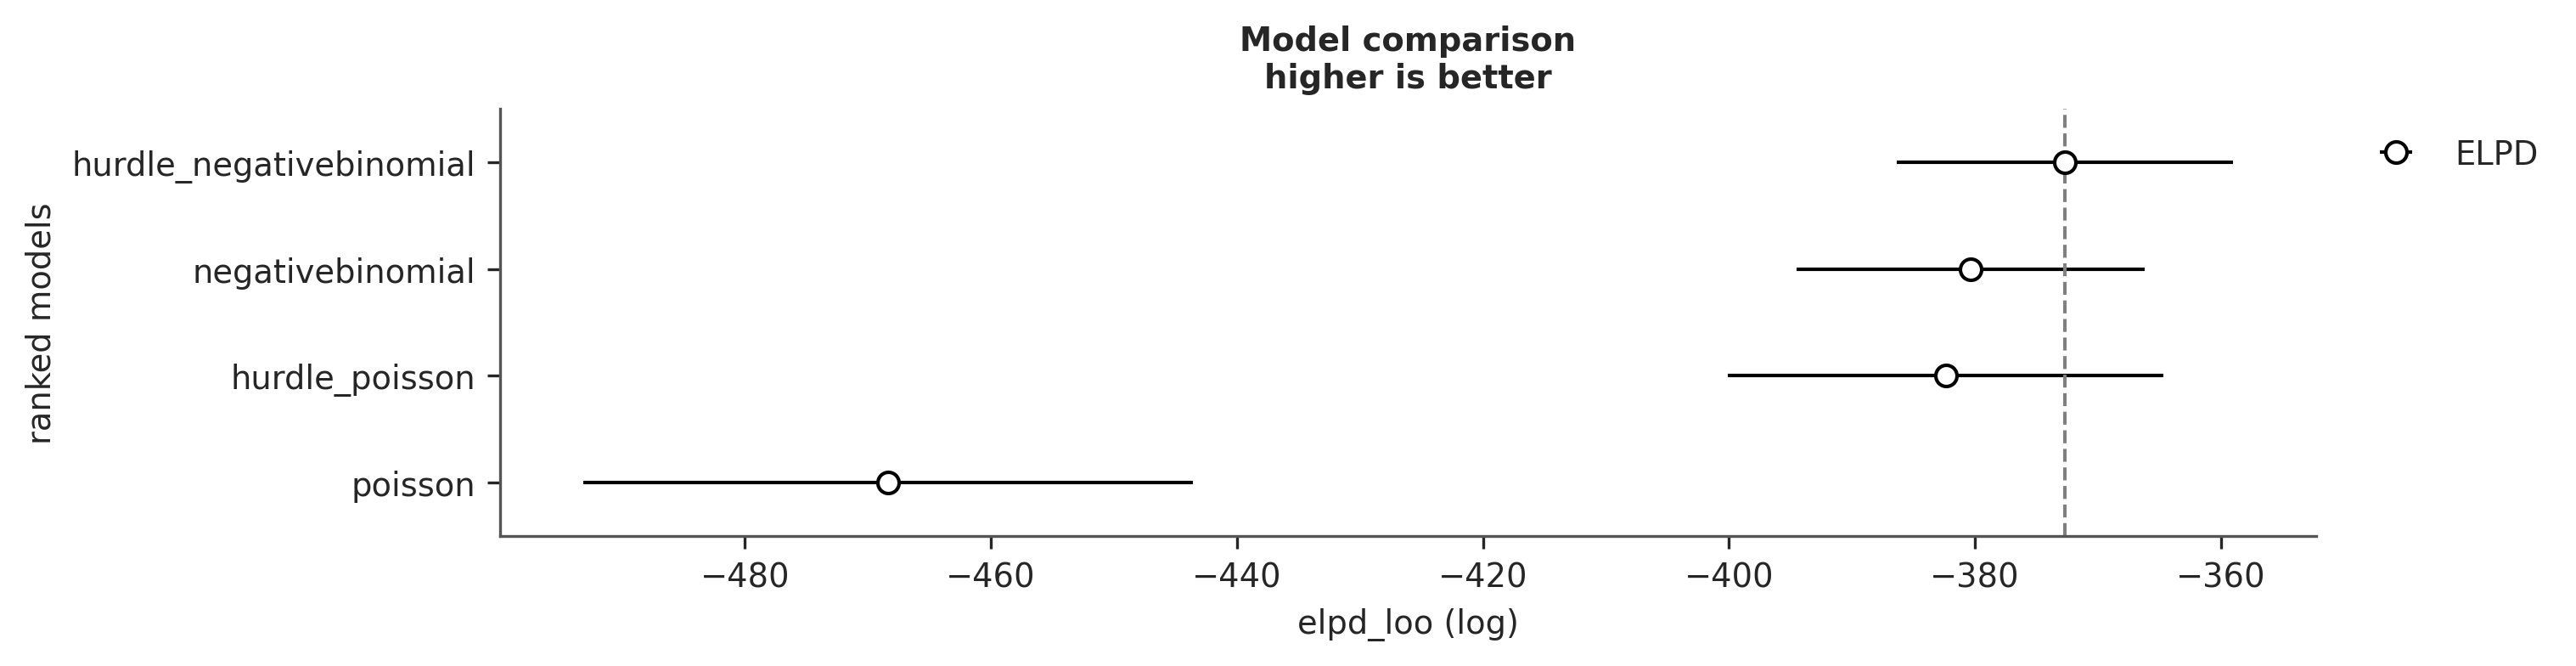

In [20]:
az.plot_compare(cmp, figsize=(10, 2.5), plot_ic_diff=False);

Una forma útil de evaluar visualmente el ajuste en modelos de conteo son los "[hanging rootograms](https://arxiv.org/abs/1605.01311)" (raizogramas colgantes), como se ve en la siguiente figura.

En los _hanging rootograms_, dibujamos las raíces cuadradas de los valores observados y predichos. Esta es una forma rápida de ajustar aproximadamente las diferencias de escala facilitando la comparación de frecuencias observadas y esperadas incluso para frecuencias bajas. En segundo lugar, las barras representando los datos observados *cuelgan* de los valores esperados, en lugar de *crecer* desde el cero. Si la barra _cae_ por debajo de cero entonces el modelo está subestimando ese valor, y si no _alcanza_ al cero es que lo está sobreestimando.

/tmp/ipykernel_39204/424556328.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = dims["chain"] * dims["draw"]


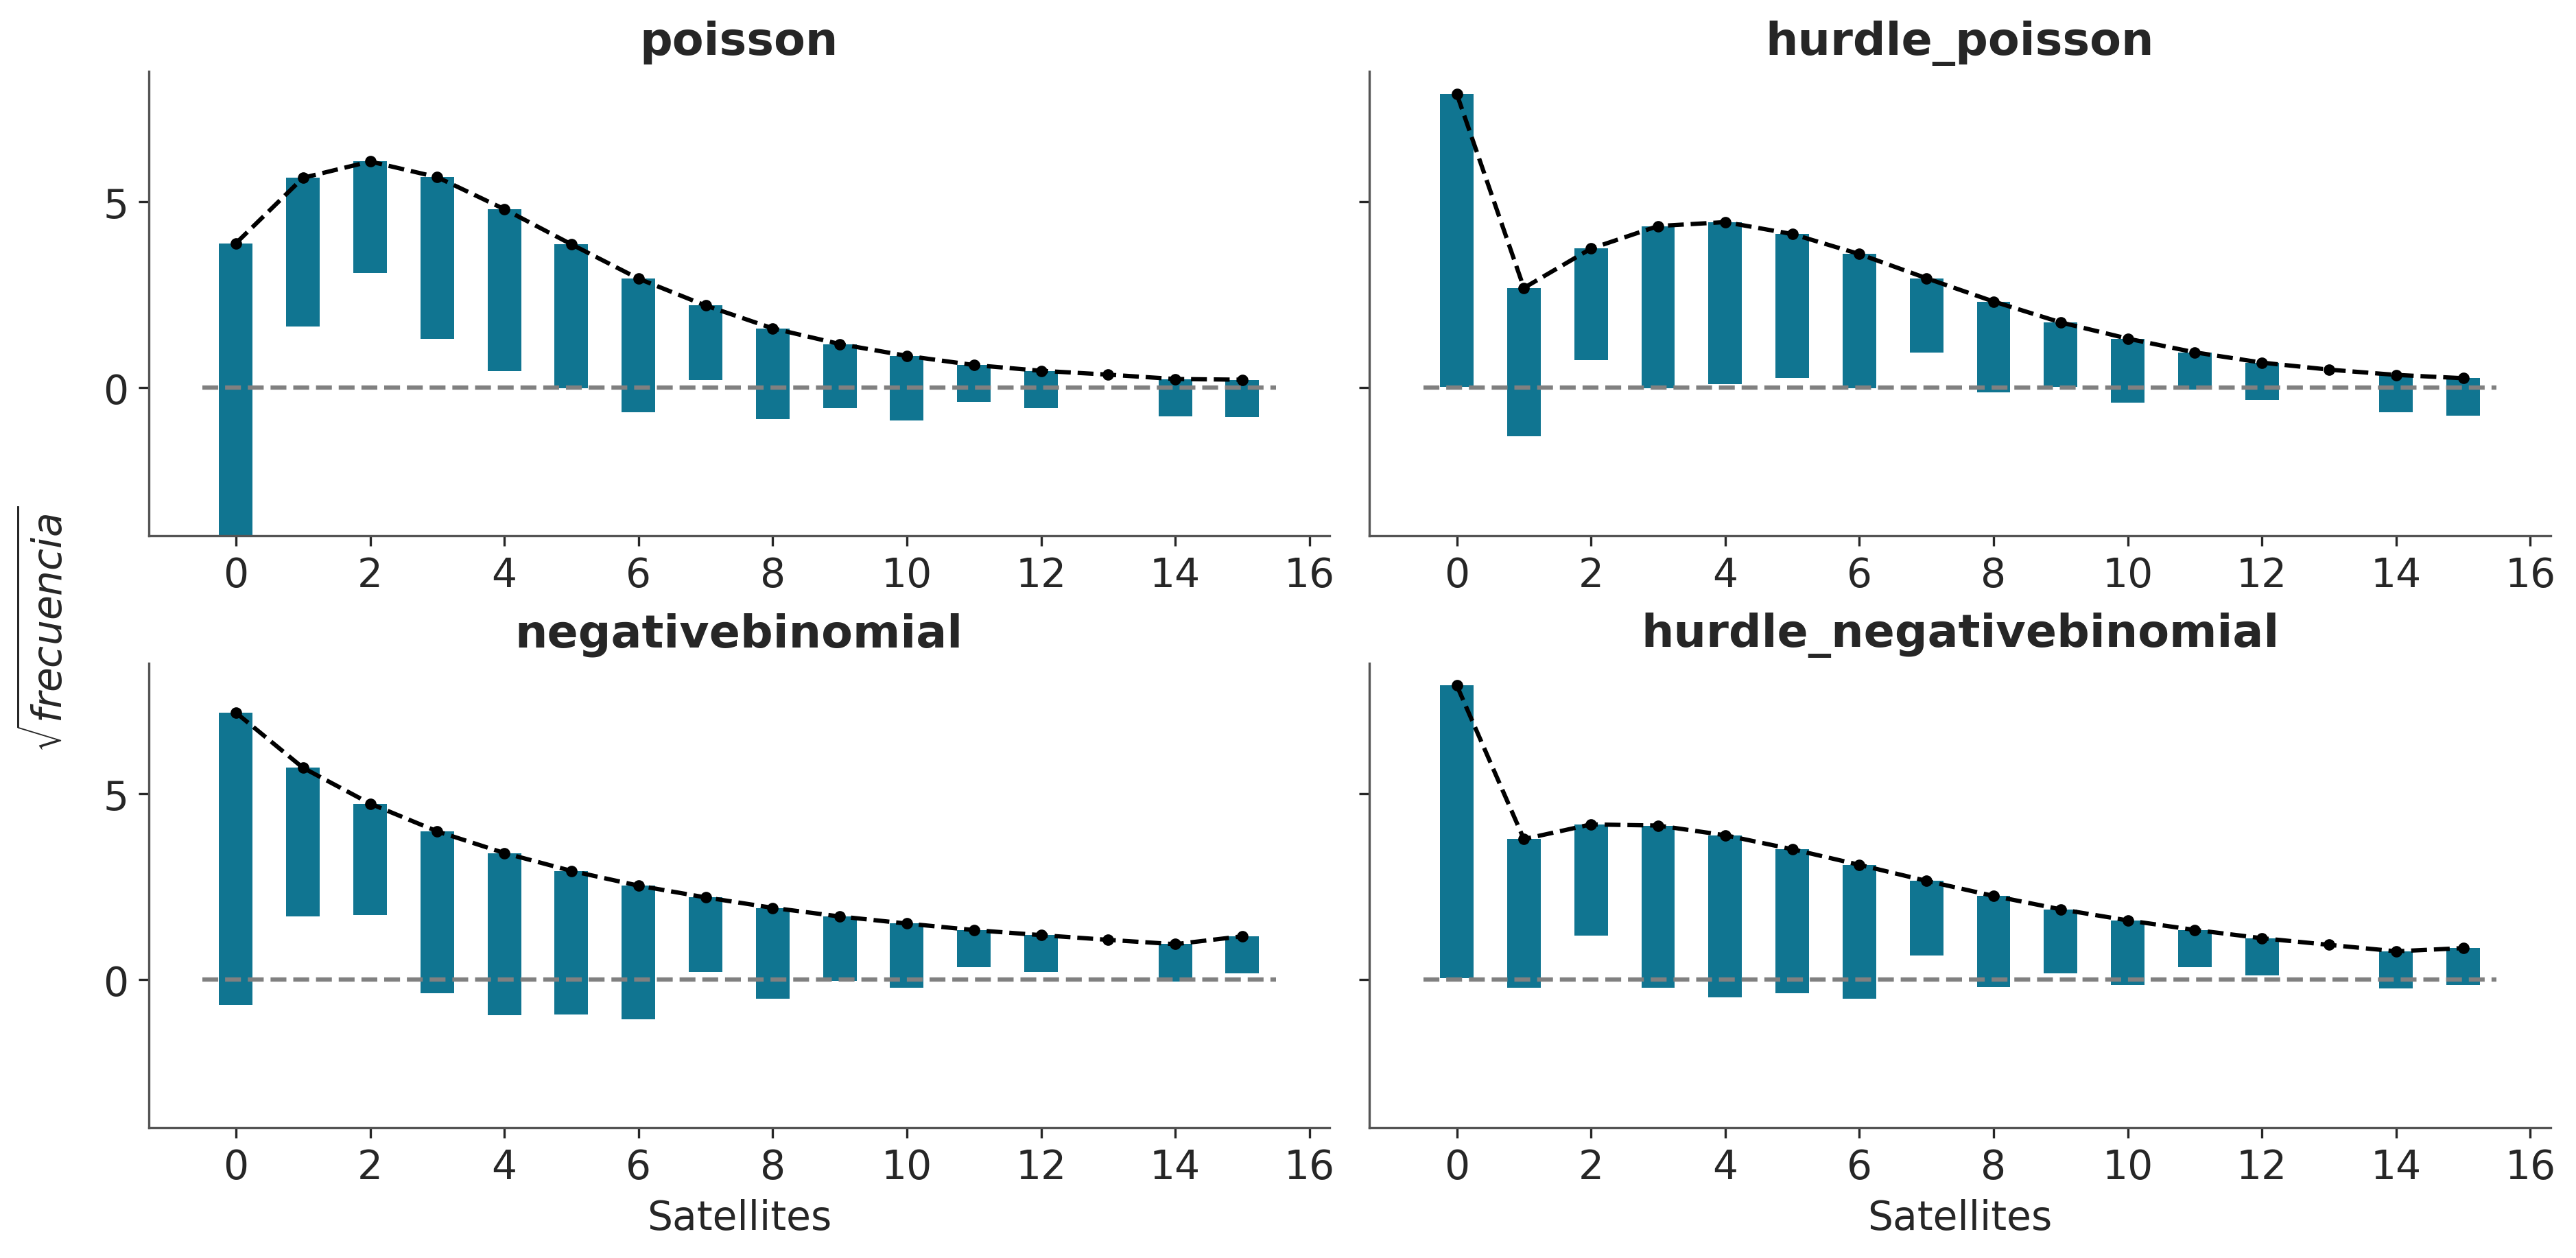

In [21]:
#| code-fold: true

def rotogram(idata, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    dims = idata.posterior_predictive.dims
    n_samples = dims["chain"] * dims["draw"]
    pred =  (np.histogram(idata.posterior_predictive["satellite"].values.ravel(),  bins=bins)[0] / n_samples)**0.5
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]**0.5

    ax.bar(bins[:-1], observed, 0.5, bottom=pred-observed, color="C0")
    ax.plot(bins[:-1], pred,  "k.--")
    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="0.5")


fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 6))
for ax, idata, model in zip(axes.ravel(), idatas, modelos):
    rotogram(idata, ax)
    ax.set_title(model.family.name)

axes[1,1].set_xlabel("Satellites")
axes[1,0].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "$\sqrt{frecuencia}$", va="center", rotation="vertical", fontsize=14);

Resumamos cada uno de los 4 paneles en la figura anterior

* Poisson: Los ceros están subestimados y los conteos del 1 al 4 están sobreestimados. La mayoría de los valores a partir de 6 también están subestimados. Este patrón indica sobredispersión en los datos, y la enorme diferencia para 0 indica un exceso de ceros.
* NegativoBinomial: Vemos que la sobredispersión se maneja mucho mejor en comparación con el modelo de Poisson. Todavía vemos que los ceros están subestimados y los valores 1 y 2 están sobreestimados, lo que probablemente indica un exceso de ceros.
* Hurdle Poisson: Como se esperaba de un modelo hurdle, obtenemos un ajuste perfecto para los ceros. Para los valores positivos todavía tenemos algunas desviaciones.
* Hurdle NegativoBinomial: Vemos que el modelo puede ajustarse muy bien a los datos, siendo las desviaciones muy pequeñas.

## Modelos mixtos no-finitos

Para algunos problemas, como intentar agrupar dígitos escritos a mano, es fácil justificar el número de grupos que esperamos encontrar en los datos. Para otros problemas, podemos tener buenas conjeturas; por ejemplo, podemos saber que nuestra muestra de flores de Iris se tomó de una región donde sólo crecen tres especies de Iris, por lo que utilizar tres componentes es un punto de partida razonable. Cuando no estamos tan seguros de la cantidad de componentes, podemos usar la selección de modelos para ayudarnos a elegir la cantidad de grupos. Sin embargo, para otros problemas, elegir a priori el número de grupos puede ser un inconveniente, o puede que nos interese estimar este número directamente a partir de los datos. Una solución Bayesiana para este tipo de problemas viene dada por el proceso de Dirichlet.

### Procesos de Dirichlet

Todos los modelos que hemos visto hasta ahora han sido modelos paramétricos, es decir, modelos con un número fijo de parámetros. En estos modelos asumimos una distribución para los datos (likelihood) y luego una distribución para los parámetros desconocidos. Pero también es posible crear modelos no-paramétricos. Este tipo de modelos no es que no tenga parámetros es que el número de parámetros es variable y depende en alguna medida de lo datos. Podemos pensar en los modelos no paramétricos como modelos con un número teóricamente infinito de parámetros junto a algún mecanismo que en la práctica nos permita trabajar con objetos finitos. 

En este curso veremos tres ejemplos de dichos modelos: el proceso gaussiano, los árboles de regresión aditiva bayesiana y el proceso de Dirichlet. 

La definición formal de un Proceso de Dirichlet (PD) es algo opaca y requiere de familiaridad con procesos estocásticos y teoría de la medida. En la literatura es común encontrarla definida de forma implicita mediante varios mecanismos alternativos. Uno de ellos es el proceso de rotura de palos. Veamos.

Primero generamos una serie de pesos:

\begin{align}
\beta_i & \sim \text{Beta}(1, \alpha) \\
w_i & = \beta_i \prod_{j=1}^{i-1} (1 - \beta_j)
\end{align}

Este proceso es análogo a imaginar que tenemos un palo de longitud 1, lo partimos en dos partes. Guardamos una de las partes y partimos la restante nuevamente, repetimos indefinidamente. Podemos ver que $\alpha$ controla el proceso de rotura. Cuando $\alpha$ se aproxima a 0, la distribución Beta se concentra hacia el valor 1, cuando $\alpha=1$ la distribución Beta es uniforme y a medida que $\alpha$ crece la distribución Beta se concentra hacia 0. Por lo que un valor alto de $\alpha$ favorece pesos pequeños.

El proceso continua asignado una ubicación $\theta_i$ al peso $w_i$:

$$
\theta_i \sim H 
$$

$H$ es la distribución base del PD.

Dados estos elementos podemos definir a un proceso de Dirichlet $G \sim DP(\alpha, H)$ como una suma pesada de masas puntuales localizadas según la distribución base.

$$
G = \sum_{i=1}^{\infty} w_i \delta_{\theta_i}
$$

donde $\delta_{\theta_i}$ es la función delta de Dirac centrada en $\theta_i$.

La siguiente figura muestra un ejemplo de una realización (muestra) de un proceso de Dirichlet para 3 valores distintos de $\alpha$.



Asi como la distribución de Dirichlet es la generalización n-dimensional de la distribución Beta, el proceso de Dirichlet es la generalización de dimensión infinita de la distribución de Dirichlet.

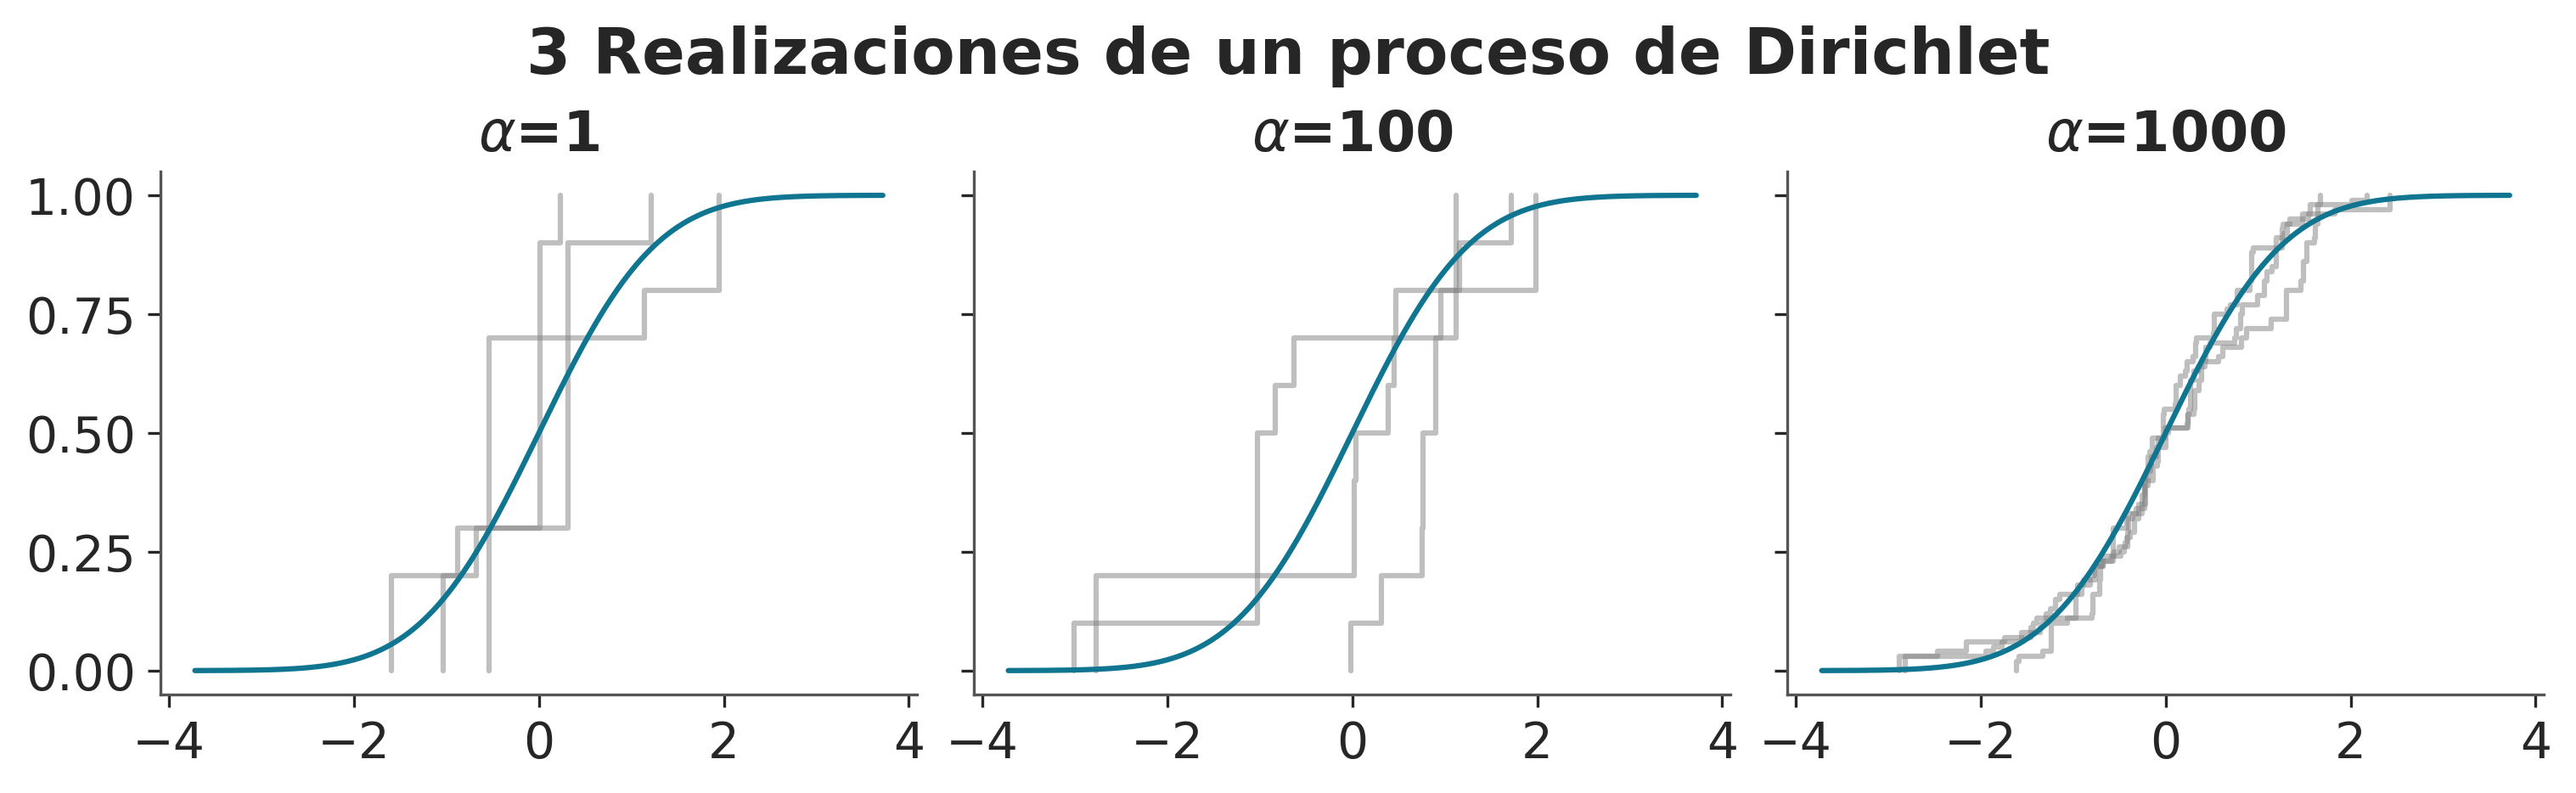

In [9]:
def stick_breaking_process(alpha, base_dist):
    """
    Generate a realization from a Dirichlet Process using the stick-breaking process.

    Parameters:
    ----------
    
    alpha : float
        Concentration parameter of the Dirichlet Process
    base_dist : PreliZ distribution
        Base distribution
    """
    K_max = max(10, int(alpha/10)) 
    beta = pz.Beta(1, alpha).rvs(K_max)
    w = np.empty(K_max)
    w[0] = beta[0]
    w[1:] = beta[1:] * (1 - beta[:-1]).cumprod()
    w /= w.sum()  

    loc = base_dist.rvs(K_max)

    samples = np.random.choice(loc, p=w, size=K_max)

    return samples

N = 3
base_distribution = pz.Normal(0, 1)

_, axes = plt.subplots(1,3, figsize=(10, 3), sharey=True)

for alpha, ax in zip([1, 100, 1000], axes.ravel()):
    for _ in range(N):
        sample = stick_breaking_process(alpha, base_distribution)
        ax.ecdf(sample, color="0.5", alpha=0.5)
        
    base_distribution.plot_cdf(legend=False, ax=ax)
    ax.set_title(fr"$\alpha$={alpha}")
    
plt.suptitle(f'{N} Realizaciones de un proceso de Dirichlet');


In [23]:
K = 10

with pm.Model() as model_DP:
    α = pm.Gamma('α', 2, 1)

    w = pm.StickBreakingWeights("w", α, K-1)
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sigma=5, shape=K,
                      transform=pm.distributions.transforms.ordered,
                     )
    
    sd = pm.HalfNormal('sd', sigma=5, shape=K)
    obs = pm.NormalMixture('obs', w, means, sigma=sd, observed=cs_exp.values)
    idata = pm.sample(random_seed=123, target_accept=0.9, nuts_sampler="nutpie")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,19,0.07,127
,2000,12,0.08,511
,2000,1,0.07,255
,2000,0,0.05,383


Debido a que estamos aproximando el DP (infinito) con un valor finito, es importante verificar que el valor de truncamiento ($K=10$ en este ejemplo) no introduzca ningún sesgo. Una forma sencilla de hacerlo es calcular el peso promedio de cada componente, ordenarlos y luego visualizar la suma acumulada. Para estar seguros, deberíamos tener al menos algunos componentes con un peso insignificante; de lo contrario, debemos aumentar el valor de truncamiento. El siguiente gráfico es un ejemplo de esto.

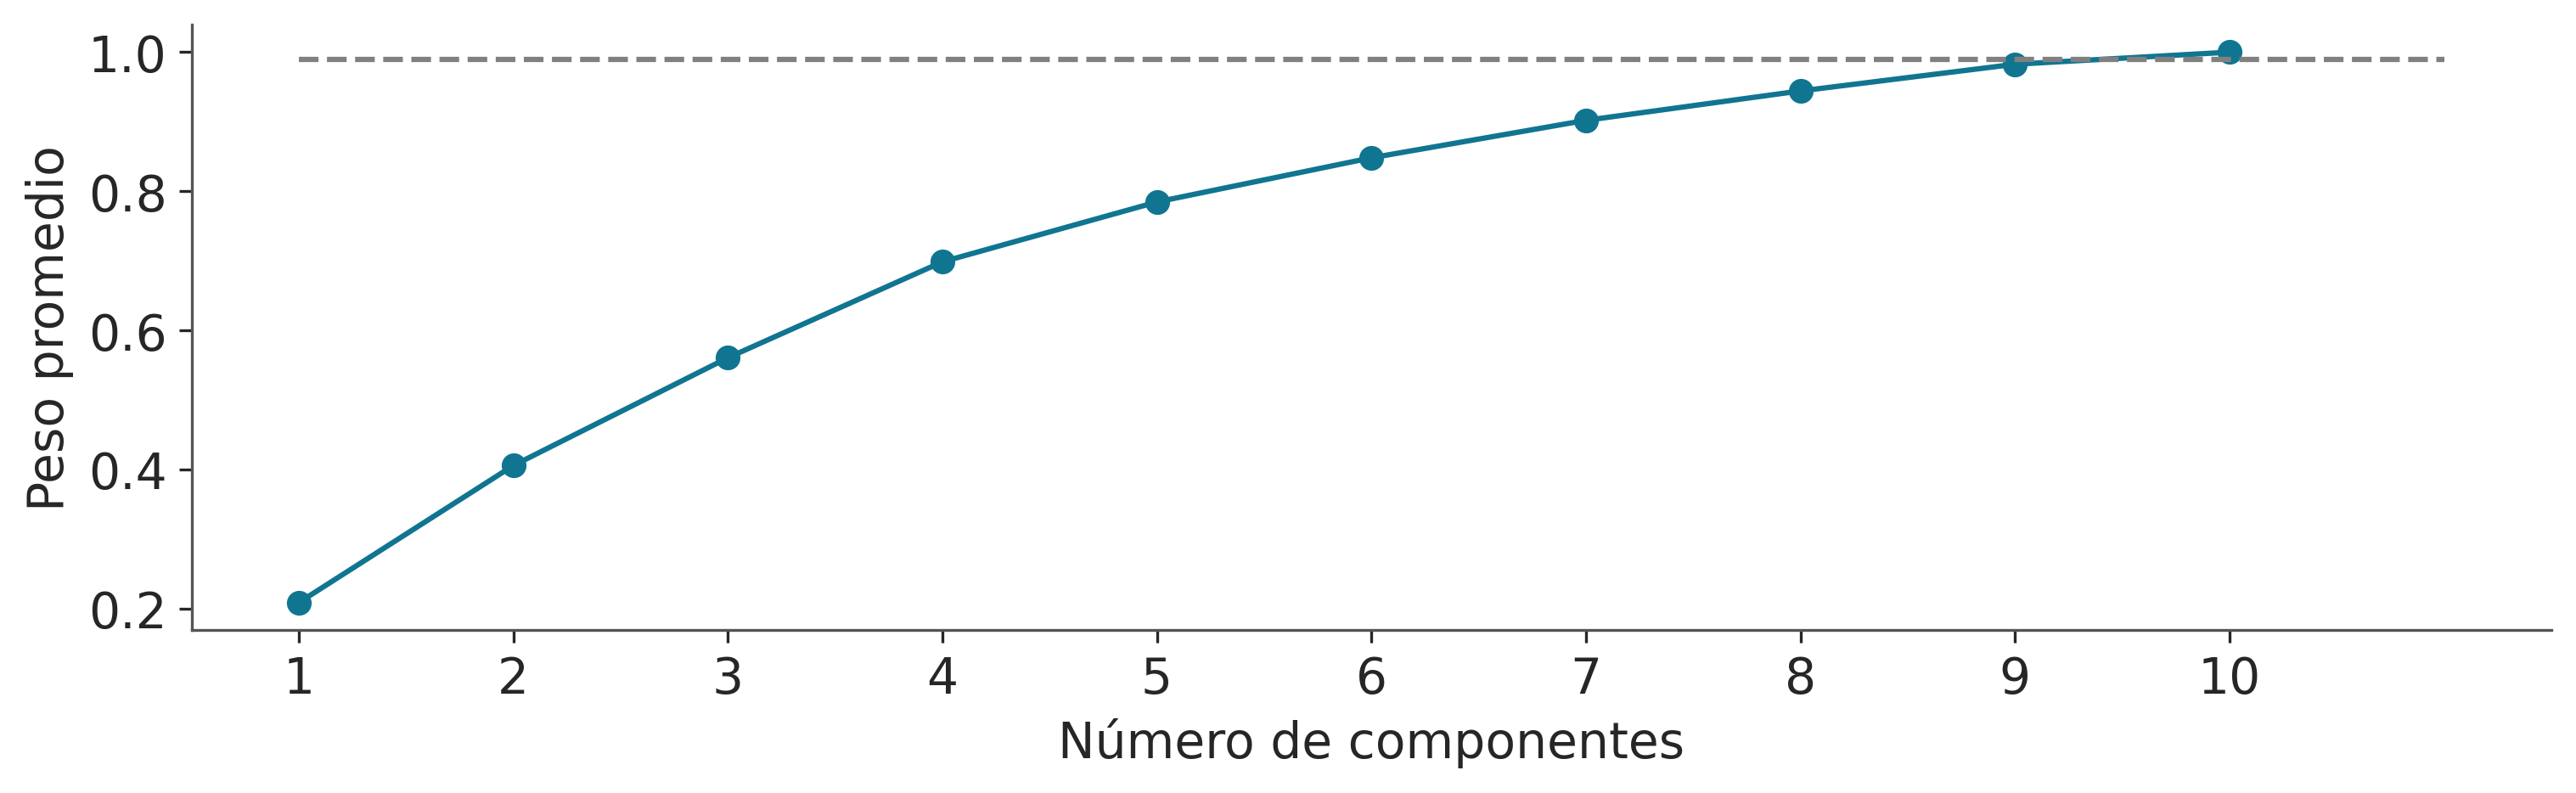

In [24]:
_, ax = plt.subplots(figsize=(10, 3))
plot_w = np.arange(K)
ax.plot(np.cumsum(np.sort(idata.posterior['w'].mean(("chain", "draw")))[::-1]), 'o-')
ax.hlines(0.99, 0, K, ls="--", color="0.5")
ax.set_xticks(plot_w, plot_w+1)
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Peso promedio');

Podemos ver que los primeros 9 componentes representan más del 99% del peso total (línea discontinua gris en la figura anterior) y por lo tanto podemos estar seguros de que el valor elegido ($K=10$) es adecuado para estos datos.

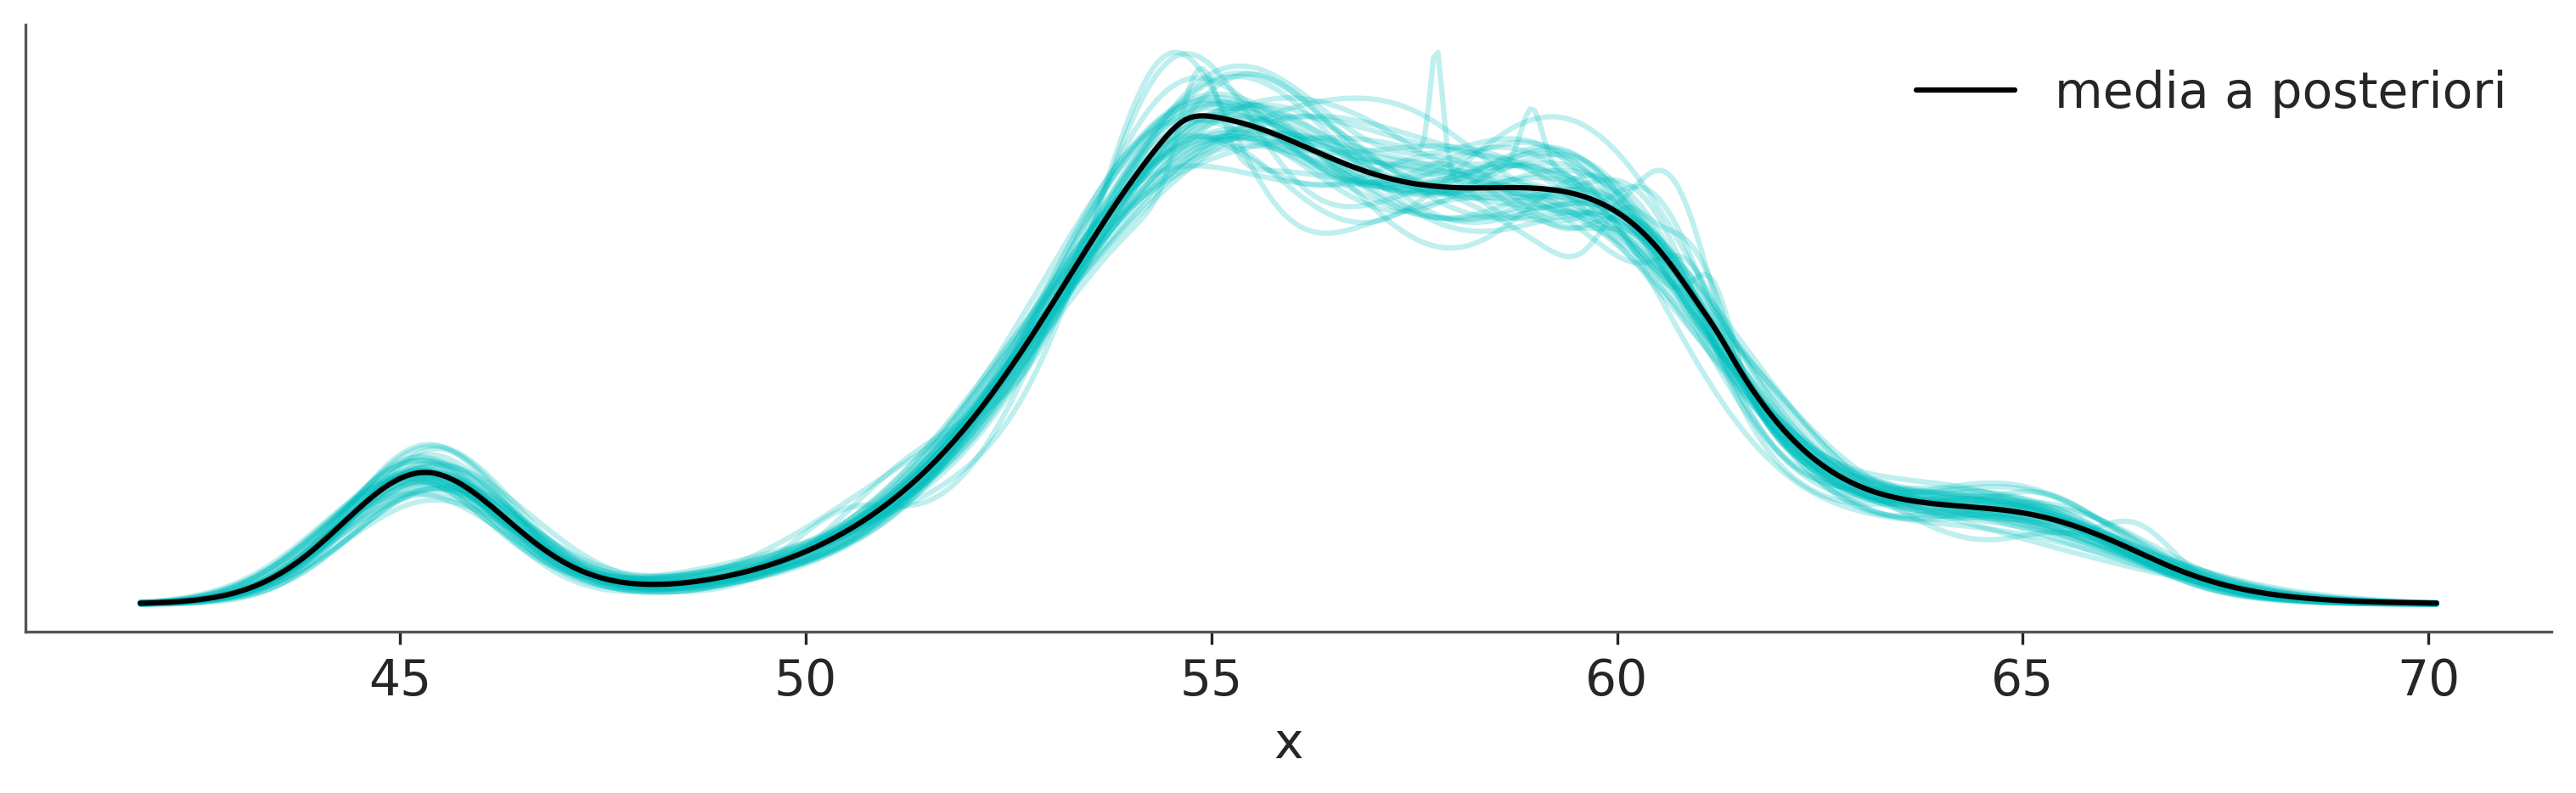

In [25]:
x_plot = np.linspace(cs_exp.min()-1, cs_exp.max()+1, 500)

posterior = idata.posterior.stack(samples=("chain", "draw"))

post_pdf_contribs = pz.Normal(posterior['means'].values[:, None, :],
                              posterior['sd'].values[:, None, :]).pdf(np.atleast_3d(x_plot))

post_pdfs = (posterior['w'].values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=0)


_, ax = plt.subplots(figsize=(10, 3))

ax.plot(x_plot, post_pdfs[:,::100], c='C1', alpha=0.25)
ax.plot(x_plot, post_pdfs.mean(axis=1), c='k', label="media a posteriori")

ax.set_xlabel('x')
ax.set_yticks([])
ax.legend();

## Mezclas continuas


El enfoque de este capítulo estuvo en los modelos de mezcla discreta, pero también podemos tener modelos de mezcla continua. Y de hecho ya conocemos algunos de ellos. Por ejemplo, los modelos jerárquicos también pueden interpretarse como modelos de mezcla continua donde los parámetros de cada grupo provienen de una distribución continua en el nivel superior. Para hacerlo más concreto, piense en realizar una regresión lineal para varios grupos. Podemos suponer que cada grupo tiene su propia pendiente o que todos los grupos comparten la misma pendiente. Alternativamente, en lugar de enmarcar nuestro problema como dos opciones discretas extremas, un modelo jerárquico nos permite modelar efectivamente una mezcla continua de estas dos opciones.

### Algunas distribuciones comunes son mezclas


BetaBinomial es una distribución discreta que generalmente se utiliza para describir el número de éxitos $y$ para $n$ ensayos de Bernoulli cuando se desconoce la probabilidad de éxito $p$ en cada ensayo y se supone que sigue una distribución beta con parámetros $\alpha$ y $\beta$:

$$
 \text{BetaBinomial}(y \mid n, \alpha,\beta) = \int_0^1 \text{Bin}(y \mid p, n) \; \text{Beta}(p \mid \alpha, \beta) dp
$$

Es decir, para encontrar la probabilidad de observar el resultado $y$, promediamos todos los valores posibles (y continuos) de $p$. Por tanto, el BetaBinomial puede considerarse como un modelo de mezcla continua. Si el modelo BetaBinomial te suena familiar es porque estuviste prestando atención en los dos primeros capítulos del libro. Este es el modelo que usamos para el problema de lanzar una moneda, aunque usamos explícitamente una distribución Beta y Binomial, en lugar de usar la distribución Beta-Binomio ya $\textit{mixta}$.

De manera similar tenemos la distribución Binomial Negativa, que puede entenderse como una mezcla Gamma-Poisson. Es decir, una mezcla de distribuciones de Poisson donde el parámetro de velocidad tiene una distribución Gamma. La distribución binomial negativa se utiliza a menudo para evitar un problema común que se encuentra al tratar con datos de conteo. Este problema se conoce como sobredispersión. Suponga que está utilizando una distribución de Poisson para modelar los datos de recuento y luego se da cuenta de que la varianza en sus datos excede la del modelo; El problema con el uso de una distribución de Poisson es que la media y la varianza se describen mediante el mismo parámetro. Una forma de explicar la sobredispersión es modelar los datos como una mezcla (continua) de distribuciones de Poisson. Al considerar una combinación de distribuciones, nuestro modelo tiene más flexibilidad y puede adaptarse mejor a la media y la varianza de los datos.

Otro ejemplo de mezcla de distribuciones es la distribución t de Student. Introdujimos esta distribución como una alternativa sólida a la distribución gaussiana. En este caso, la distribución t resulta de una mezcla de distribuciones gaussianas con media $\mu$ y varianza desconocida distribuida como una distribución Gamma inversa.

## Resumen

Muchos problemas pueden describirse como una población general compuesta de distintas subpoblaciones. Cuando sabemos a qué subpoblación pertenece cada observación, podemos modelar específicamente cada subpoblación como un grupo separado. Sin embargo, muchas veces no tenemos acceso directo a esta información, por lo que puede ser apropiado modelar esos datos utilizando modelos mixtos. Podemos utilizar modelos mixtos para intentar capturar subpoblaciones reales en los datos o como un truco estadístico general para modelar distribuciones complejas combinando distribuciones más simples.

En este capítulo, dividimos los modelos de mezclas en tres clases: modelos de mezclas finitas, modelos de mezclas no finitas y modelos de mezclas continuas. Un modelo de mezcla finita es una mezcla finita ponderada de dos o más distribuciones, donde cada distribución o componente representa un subgrupo de datos. En principio, los componentes pueden ser prácticamente cualquier cosa que consideremos útil, desde distribuciones simples, como una gaussiana o una Poisson, hasta objetos más complejos, como modelos jerárquicos o redes neuronales. Conceptualmente, para resolver un modelo mixto, todo lo que necesitamos hacer es asignar adecuadamente cada punto de datos a uno de los componentes. Podemos hacer esto introduciendo una variable latente $z$. Usamos una distribución categórica para $z$, que es la distribución discreta más general, con un previo de Dirichlet, que es la generalización n-dimensional de la distribución Beta. El muestreo de la variable discreta $z$ puede ser problemático, por lo que puede resultar conveniente marginarla. PyMC incluye una distribución de mezcla normal y una distribución de mezcla que realiza esta marginación por nosotros, lo que facilita la construcción de modelos de mezcla con PyMC.

Un problema común que analizamos en este capítulo cuando trabajamos con modelos mixtos es que este modelo puede conducir al problema de cambio de etiqueta, una forma de no identificabilidad. Una forma de eliminar la no identificabilidad es forzar el pedido de los componentes. Un desafío con los modelos de mezclas finitas es cómo decidir el número de componentes. Una solución es realizar una comparación de modelos para un conjunto de modelos en torno a un número estimado de componentes. Esa estimación debe guiarse, cuando sea posible, por nuestro conocimiento del problema en cuestión. Otra opción es intentar estimar automáticamente la cantidad de componentes a partir de los datos. Por esta razón, introdujimos el concepto del proceso de Dirichlet como una versión de dimensión infinita de la distribución de Dirichlet que podemos usar para construir un modelo de mezcla no paramétrico.

Finalmente, para cerrar el capítulo, discutimos brevemente cuántos modelos, como el BetaBinomial (el que se usa para el problema de lanzar una moneda), el Binomial Negativo, la distribución t de Student e incluso los modelos jerárquicos, pueden interpretarse como modelos de mezcla continua.

## Ejercicios

1. Generar datos sintéticos a partir de una mezcla de 3 gaussianas (por ejemplo usando PreliZ). Ajustar un modelo de mezcla gaussiana finita con 2, 3 o 4 componentes.
2. Usar LOO para comparar los resultados del ejercicio 1.
3. Leer y ejecutar el siguiente ejemplo sobre modelos de mezcla de la documentación de PyMC. Modelo de
[mezcla gaussiana marginalizada](https://www.pymc.io/projects/examples/en/latest/mixture_models/marginalized_gaussian_mixture_model.html)
4. Usando los datos de pezca ajuste un modelo NegativeBinomial y un Hurdle-NegativeBinomial. Use rootogramas para comparar estos dos modelos con el modelo de Poisson inflado de ceros.
5. Repita el ejercicio 1 utilizando un proceso de Dirichlet.
6. Suponiendo por un momento que no conoce las especies/etiquetas correctas para el conjunto de datos de iris, utilice un modelo de mezcla para agrupar las tres especies de iris, utilizando una característica de su elección (como la longitud del sépalo).